In [87]:
import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import sys 
import torch
import torch.nn as nn
from torchvision import models, transforms
import PIL
from skimage.transform import resize
import torch.nn.functional as F
import matplotlib.cm as cm
import shutil


p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid
from scipy.optimize import curve_fit

import notebooks_utils

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # to result sketches of the semantic simplification (first row) 
path_to_files = "/home/vinker/dev/input_images/background_sketching/" # to input images

# Utils

In [112]:
def ratios_to_str(ratios):
    ratios_str = ""
    for r_ in ratios:
        r_str = f"{r_:.3f}"
        ratios_str += f"{float(r_str)},"
    ratios_str = ratios_str[:-1]
    return ratios_str

def get_clip_loss(path, layer, object_or_background):
    path_config = f"{path}/config.npy"
    config = np.load(path_config, allow_pickle=True)[()]
    loss_clip = np.array(config[f"loss_eval"])
    best_iter = np.argsort(loss_clip)[0]
    loss_clip_layer = np.array(config[f"clip_vit_l{layer}_original_eval"])
    if object_or_background == "object":
        loss_clip_layer4 = np.array(config[f"clip_vit_l4_original_eval"])
        loss_clip_layer = 1*loss_clip_layer4 + loss_clip_layer
    return best_iter, loss_clip_layer

def func(x, a, c, d):
    return a*np.exp(c*x)

def func_inv(y,a,c,d):
    return np.log(y / a) * (1 / c)

def get_func(ratios_rel, start_x, start_ys):
    target_ys = ratios_rel[start_ys:]
    x = np.linspace(start_x, start_x + len(target_ys) - 1, len(target_ys))
    # calculate polynomial
    popt, pcov = curve_fit(func, x, target_ys, maxfev=3000)
    return popt

def get_ratios_srt2(path_to_initial_sketches, folder_name_l, layer, object_or_background, step_size_l, num_ratios=8):
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{folder_name_l}")
    seed = notebooks_utils.get_seed(svg_filename)
    path_li = f"{path_to_initial_sketches}/{folder_name_l}/{folder_name_l}_seed{seed}"
    best_iter, loss_clip_layer = get_clip_loss(path_li, layer, object_or_background)
    best_lclip_layer = loss_clip_layer[best_iter]
    r_1_k = 1 / best_lclip_layer
    
    # get the next ratios by jumping by 2
    r_j_k = r_1_k
    ratios_k = [r_1_k]
    for j in range(4):
        r_j_k = r_j_k / 2
        ratios_k.append(r_j_k)
    start_ys, start_x, end_x_addition = 0, 0, 0
    popt = get_func(ratios_k, start_x=0, start_ys=0) # fit the function to ratios_k
    # print(popt)
    # print(f"function :a*exp(c*x)")
    x_1_k = func_inv([r_1_k], *popt)

    step_size = step_size_l
    num_steps = num_ratios - start_x + end_x_addition
    start_ = x_1_k[0]
    end = num_steps * step_size
    # sample the function from the initial scaled r_1 with the corresponding step size
    new_xs_layer_l = np.linspace(start_, end - step_size + start_, num_steps) 
    # print("new_xs_layer_l", new_xs_layer_l)
    ratios_li = func(new_xs_layer_l, *popt)
    ratios_str = ratios_to_str(ratios_li)
    xs_layer_l_str = ratios_to_str(new_xs_layer_l)
    # print(f"layer {layer} r_1_k {r_1_k} \n new {ratios_str} \n x {xs_layer_l_str}\n")
    return ratios_str

def init_dict(layers):
    d = {}
    for l in layers:
        d[l] = {}
    return d

def draw_graph(ys, layer, i, colors, ylabel, xlabel, title, label=None, x_vals=None):
    if x_vals is None:
        x_vals = range(len(ys))
        plt.plot(x_vals, ys, c=np.array([colors[i]]))
        for k in range(len(ys)):
            plt.annotate("{:.2f}".format(ys[k]), (x_vals[k], ys[k]), fontsize=10)
    else:
        for k in range(len(ys)):
            plt.annotate("{:.0f}".format(k), (x_vals[k], ys[k]), fontsize=10)
    if label is None:
        label = f"layer {layer}"
        
    plt.scatter(x_vals, ys, label=label, s=20, c=np.array([colors[i]]))
    
    plt.ylabel(ylabel, fontsize=10)
    plt.xlabel(xlabel, fontsize=10)
    plt.title(title)
    plt.legend()

def get_semantic_image(res_filename, resize_obj, params):
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{res_filename}")
    path_svg = f"{path_to_initial_sketches}/{res_filename}/{svg_filename}"
    im = notebooks_utils.read_svg(path_svg, resize_obj=resize_obj, params=params)
    return im


def get_res_filename(im_name_, object_or_background, layer, resize_obj):
    im_name = im_name_
    if object_or_background == "background":
        im_name = f"{im_name_}_mask"
    res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
    if resize_obj:
        res_filename += f"_resize{resize_obj}"
    path_res = f"{path_to_initial_sketches}/{res_filename}"
    if not os.path.isdir(path_res):
        res_filename = f"{res_filename}_resize{resize_obj}"
    return res_filename

def get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, ablation_name_pref=""):
    test_name_pref = f"l{layer}_64s_{im_name}_{min_div}{ablation_name_pref}"
    if resize_obj:
        test_name_pref += f"_resize{resize_obj}"
    res_filename = f"ratio{r}_{test_name_pref}"
    path_res = f"{path_to_res}/{res_filename}"
    if not os.path.isdir(path_res):
        res_filename = f"{res_filename}_resize{resize_obj}"
    path_res = f"{path_to_res}/{res_filename}"
    if not os.path.isdir(path_res):
        test_name_pref = f"l{layer}_64s_{im_name}_{ablation_name_pref}"
        res_filename = f"ratio{r}_{test_name_pref}"
    return res_filename    


def get_single_layer_stat(layer, ratios, im_name, min_div, resize_obj, ablation_name_pref=""):
    ratios_res = []
    num_strokes_res = []
    clip_loss_res = []
    for j, r in enumerate(ratios):
        res_filename = get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, ablation_name_pref=ablation_name_pref)
        best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res}/{res_filename}")
        path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"

        seed = notebooks_utils.get_seed(os.path.split(path_best_im)[-1])
        path_conf = f"{path_to_res}/{res_filename}/{res_filename}_seed{seed}/config.npy"
        config = np.load(path_conf, allow_pickle=True)[()]

        loss_clip = np.array(config[f"clip_vit_l{layer}_original_eval"])
        loss_width = np.array(config["width_loss_original_eval"])
        best_iter = int(config["best_normalised_iter"] / config["eval_interval"])

        width_loss_ = loss_width[best_iter]
        clip_loss_ = loss_clip[best_iter]
        ratio = width_loss_ / clip_loss_
        ratios_res.append(ratio)

        num_strokes = np.array(config["num_strokes"])[best_iter].cpu()
        num_strokes_res.append(num_strokes)                
        clip_loss_res.append(clip_loss_)
    return ratios_res, num_strokes_res, clip_loss_res


def get_layer_stats(object_or_background, images, layers, path_to_res, divs, step=1, resize_obj=0):
    final_ratio_per_l_per_im, final_num_s_per_l_per_im, ratios_dict_per_layer_per_im, clip_loss_dict_per_layer_per_im = init_dict(layers), init_dict(layers), init_dict(layers), init_dict(layers)

    for im_name_ in images:
        im_name = im_name_
        if object_or_background == "background":
            im_name = f"{im_name_}_mask"
            
        for i, layer in enumerate(layers):
            # print(im_name_, object_or_background, layer, resize_obj)
            res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
            min_div = divs[i]
            ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
            ratios = [float(item) for item in ratios_str.split(',')]
            ratios_dict_per_layer_per_im[layer][im_name] = ratios
            
            ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, min_div, resize_obj)

            final_ratio_per_l_per_im[layer][im_name] = ratios_res
            final_num_s_per_l_per_im[layer][im_name] = num_strokes_res
            clip_loss_dict_per_layer_per_im[layer][im_name] = clip_loss_res


    # plot graphs
    # for im_name in images:
        figa = plt.figure(figsize=(15,10))
        colors = cm.rainbow(np.linspace(0, 1, 4))
        for i, layer in enumerate(layers):        
            ratios = ratios_dict_per_layer_per_im[layer][im_name]
            clip_loss = clip_loss_dict_per_layer_per_im[layer][im_name]
            ratios_res = final_ratio_per_l_per_im[layer][im_name]
            num_strokes_res = final_num_s_per_l_per_im[layer][im_name] 

            plt.subplot(2,2,1)
            draw_graph(ratios, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios (new)")
            # print(f"layer {layer}, {ratios}")
            
            plt.subplot(2,2,2)
            # draw_graph(clip_loss, layer, i, colors, "Ratios", "Step (abstraction)", "CLIP loss", label="target ratios")
            # draw_graph(ratios, layer, i, colors, "Ratios", "Step (abstraction)", "Ratios", label="target ratios")
            draw_graph(num_strokes_res, layer, i + 2, colors, "Lsimp to CLIP", "CLIP", "Num strokes", x_vals=clip_loss)

            plt.subplot(2,2,3)
            draw_graph(ratios_res, layer, i, colors, "Ratios (new)", "Step (abstraction)", "Result Ratios")

            plt.subplot(2,2,4)
            draw_graph(num_strokes_res, layer, i, colors, "Ratios (new)", "Step (abstraction)", "Num Strokes")
            
            
        plt.legend()
        plt.tight_layout()
        # plt.savefig(f"matrix_07_09/{im_name}_graph.png")
        plt.show()
        plt.close()
        
        
def get_sketches(layer, ratios, im_name, min_div, resize_obj, path_to_res, params, ablation_name_pref=""):
    images = []
    for j, r in enumerate(ratios):
        res_filename = get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, ablation_name_pref=ablation_name_pref)
        best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res}/{res_filename}")
        path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"
        # print(path_best_im)
        im = notebooks_utils.read_svg(path_best_im, resize_obj=resize_obj, params=params, multiply=True, device=device)
        images.append(im)
    return images
    
    
def draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, divs, step=1, resize_obj=0):
    
    for im_name_ in images:
        target_path = f"{path_to_files}/{im_name_}.jpg"
        target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
        im_name = im_name_
        if object_or_background == "background":
            im_name = f"{im_name_}_mask"
            
        figa = plt.figure(figsize=(len(layers)*2, 8*2))
        # figa = plt.figure(figsize=(7,10))
        for i, layer in enumerate(layers):
            res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
            im = get_semantic_image(res_filename, resize_obj, params)
            
            min_div = divs[i]
            ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
            ratios = [float(item) for item in ratios_str.split(',')]
            k = 0
            images = get_sketches(layer, ratios, im_name, min_div, resize_obj, path_to_res, params)
            for j in range(len(images)):
                if j % step == 0:
                    plt.subplot(len(images) + 1, len(layers), (k + 1) * len(layers) + i + 1)
                    plt.imshow(images[j])
                    plt.axis("off")
                    k += 1
        plt.tight_layout()
        # plt.savefig(f"matrix_07_09/{im_name}.png")
        plt.show()
        plt.close()

def draw_images(images, step, im_name="", output_path="", save_results=0):
    # figa = plt.figure(figsize=(2, len(images)*2))
    figa = plt.figure(figsize=(len(images)*2, 2))
    k = 0
    for j in range(len(images)):
        if j % step == 0:
            # plt.subplot(len(images) + 1, 1, (k + 1) + 1)
            plt.subplot(1,len(images) + 1, (k + 1) + 1)
            plt.imshow(images[j])
            plt.axis("off")
            k += 1
        if save_results:
            filename = f"{im_name}_abs{k}"
            im_ = images[j]
            im_ = ((im_ / im_.max()) * 255).astype(np.uint8)
            imageio.imsave(f"{output_path}/{filename}.png", im_)
    plt.tight_layout()
    # plt.savefig(f"matrix_07_09/{im_name}.png")
    plt.show()
    plt.close()
    
def plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name="", output_path="", save_results=0):
    ylabel = "Lsparse"
    xlabel = "Lclip"
    ys = np.array(num_strokes_res) / 64
    x_vals = clip_loss_res
    scaled_z = np.array(range(len(num_strokes_res))) / len(num_strokes_res)
    colormap = plt.cm.get_cmap('plasma') # 'plasma' or 'viridis'
    colors = colormap(scaled_z)
    sc = plt.scatter(x_vals, ys, s=80,c=colors)
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=len(num_strokes_res))
    plt.colorbar(sm)
    for k in range(len(ys)):
        if x_vals is None:
            plt.annotate("{:.2f}".format(ys[k]), (x_vals[k], ys[k]), fontsize=10)
        else:
            plt.annotate("{:.0f}".format(k), (x_vals[k], ys[k]), fontsize=10)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.title("Lsparse(Lclip)", fontsize=18)
    plt.grid()
    plt.tight_layout()
    if save_results:
        plt.savefig(f"{output_path}/{im_name}.png", dpi=300)

def plot_num_strokes(num_strokes_res, im_name="", output_path="", save_results=0):
    ylabel = "Num Strokes"
    xlabel = "Step"
    ys = num_strokes_res
    x_vals = range(len(num_strokes_res))
    scaled_z = np.array(range(len(num_strokes_res))) / len(num_strokes_res)
    colormap = plt.cm.get_cmap('plasma') # 'plasma' or 'viridis'
    colors = colormap(scaled_z)
    sc = plt.scatter(x_vals, ys, s=80,c=colors)
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=len(num_strokes_res))
    plt.colorbar(sm)
    for k in range(len(ys)):
        plt.annotate("{:.2f}".format(ys[k]), (x_vals[k], ys[k]), fontsize=10)
       
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.title("Num Strokes", fontsize=18)
    plt.grid()
    plt.tight_layout()
    if save_results:
        plt.savefig(f"{output_path}/{im_name}.png", dpi=300)

# Test 6 - same step sizes for f_k

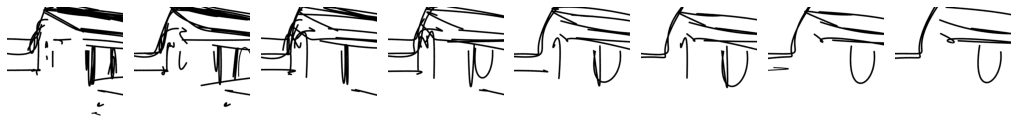

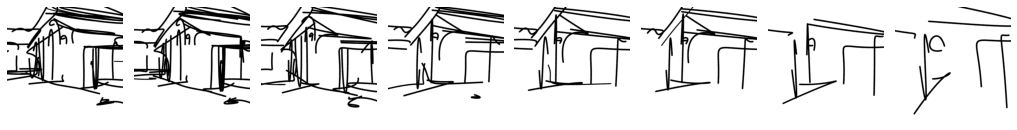

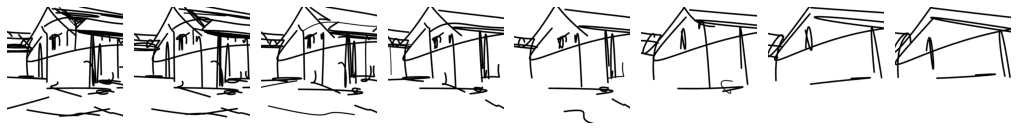

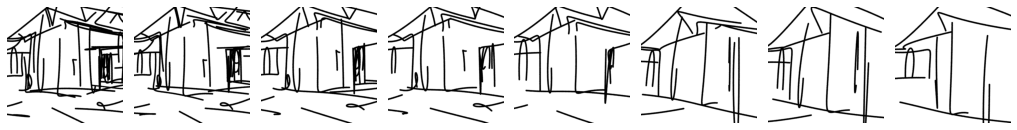

In [124]:
step = "0.5"

layers = [2, 7,8,11]
divs = [float(step), float(step), float(step), float(step)]
resize_obj=0
object_or_background = "background"
images = ["woman_city", "semi-complex", "man_flowers"]
images = ["semi-complex"]
save_results=1
output_path = f"/home/vinker/dev/background_project/paper_results/ablations/stepsize{step}"

for im_name_ in images:
    im_name = f"{im_name_}_mask"
    for i, layer in enumerate(layers):
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_org = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)        
        ratios = [float(item) for item in ratios_org.split(',')]
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        # path_to_res = f"/home/vinker/dev/background_project/experiements/step{step}_fix/fk_step1_fix"
        path_to_res = f"/home/vinker/dev/background_project/experiements/fk_step05_fix"
        images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None)
        draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_step{step}", output_path=output_path, save_results=save_results)
        # ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, divs[i], resize_obj)
        # plt.figure(figsize=(10,4))
        # # plt.figure(figsize=(5,4))
        # plt.subplot(1,2,1)
        # plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name=f"l{layer}_{im_name_}_step1_lclip2lsparse", output_path=output_path, save_results=save_results)
        # # plt.show()
        # # plt.close()
        # plt.subplot(1,2,2)
        # # plt.figure(figsize=(5,4))
        # plot_num_strokes(num_strokes_res, im_name=f"l{layer}_{im_name_}_step1_nstrokes", output_path=output_path, save_results=save_results)
        # plt.show()
        # plt.close()
    

In [8]:
# path_best_im = "/home/vinker/dev/background_project/experiements/step0.5/ratio34.479_l2_64s_man_flowers_mask_0.5/ratio34.479_l2_64s_man_flowers_mask_0.5_seed0_best.svg"
path_best_im = "/home/vinker/dev/background_project/experiements/step1//ratio34.479_l2_64s_man_flowers_mask_1.0/ratio34.479_l2_64s_man_flowers_mask_1.0_seed0_best.svg"
im = notebooks_utils.read_svg(path_best_im, resize_obj=0, params=None, multiply=True, device=device)

1
None True 0
224 224
2
3
4
5
6
7
8


In [21]:
path_c = "/home/vinker/dev/background_project/experiements/noLsparse/ratio0.068_l11_64s_woman_city_mask_0.9/ratio0.068_l11_64s_woman_city_mask_0.9_seed0/config.npy"
path_c = "/home/vinker/dev/background_project/experiements/ablation_ratios_13_10/ratio0.667_l11_64s_woman_city_mask_linear8/ratio0.667_l11_64s_woman_city_mask_linear8_seed1000/config.npy"
config = np.load(path_c, allow_pickle=True)[()]
print(config["load_points_opt_weights"])

1


# Test 9 - same r8

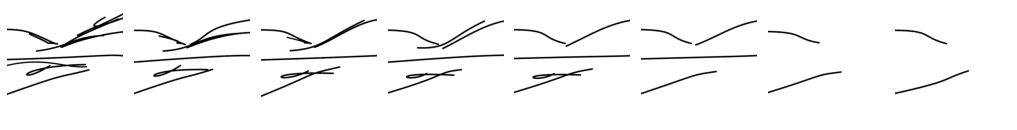

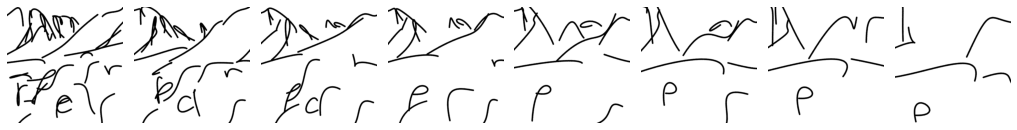

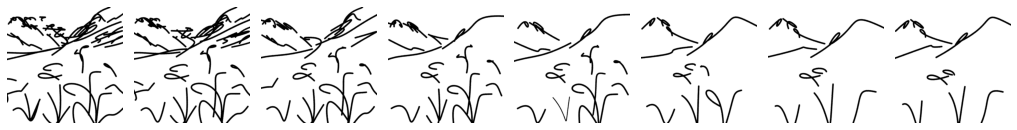

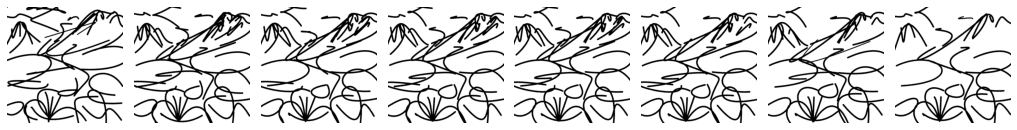

In [127]:
step = "0.5"

layers = [2, 7,8,11]
divs = [float(step), float(step), float(step), float(step)]
resize_obj=0
object_or_background = "background"
images = ["woman_city", "semi-complex", "man_flowers"]
images = ["man_flowers"]
save_results=1
output_path = f"/home/vinker/dev/background_project/paper_results/ablations/sameR8"

for im_name_ in images:
    im_name = f"{im_name_}_mask"
    for i, layer in enumerate(layers):
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_org = "16.661,11.781,8.331,5.891,4.165,2.945,2.083,1.473"
        #get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)        
        ratios = [float(item) for item in ratios_org.split(',')]
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        # path_to_res = f"/home/vinker/dev/background_project/experiements/step{step}_fix/fk_step1_fix"
        path_to_res = f"/home/vinker/dev/background_project/experiements/sameR8"
        images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None)
        draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_step{step}", output_path=output_path, save_results=save_results)
        # ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, divs[i], resize_obj)
        # plt.figure(figsize=(10,4))
        # # plt.figure(figsize=(5,4))
        # plt.subplot(1,2,1)
        # plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name=f"l{layer}_{im_name_}_step1_lclip2lsparse", output_path=output_path, save_results=save_results)
        # # plt.show()
        # # plt.close()
        # plt.subplot(1,2,2)
        # # plt.figure(figsize=(5,4))
        # plot_num_strokes(num_strokes_res, im_name=f"l{layer}_{im_name_}_step1_nstrokes", output_path=output_path, save_results=save_results)
        # plt.show()
        # plt.close()

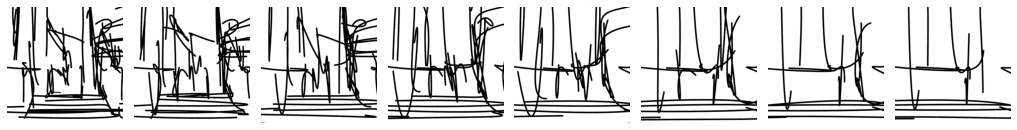

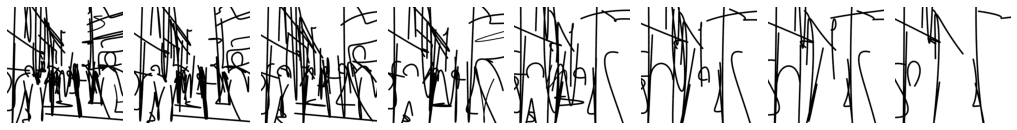

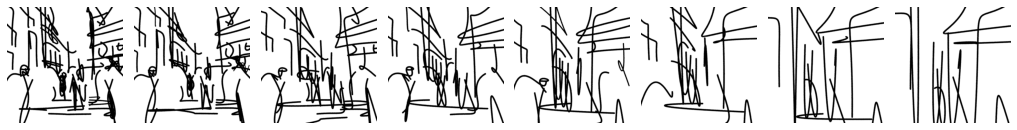

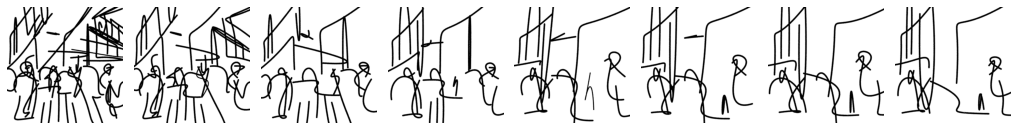

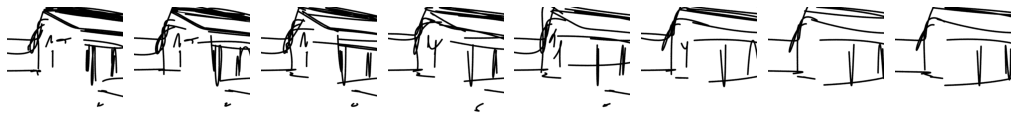

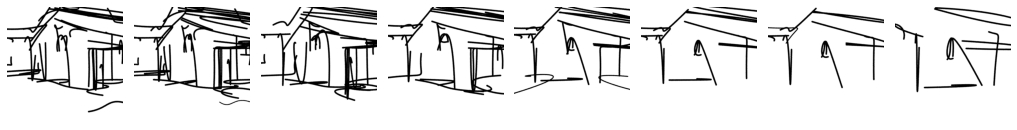

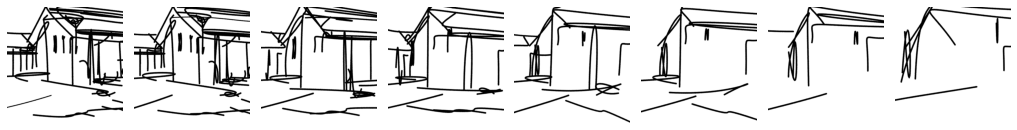

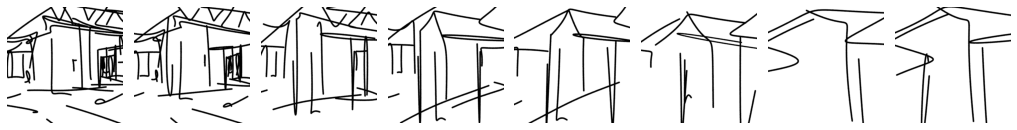

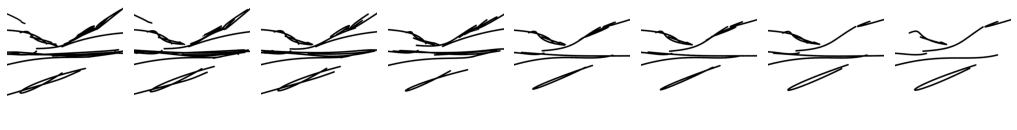

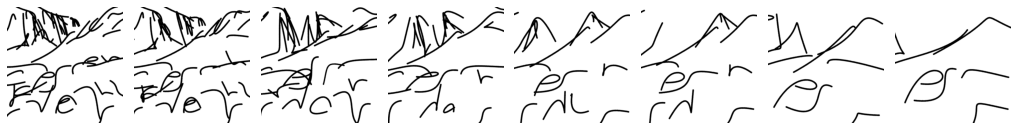

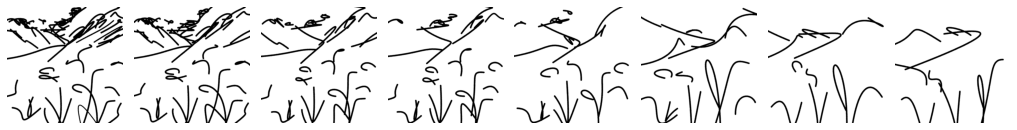

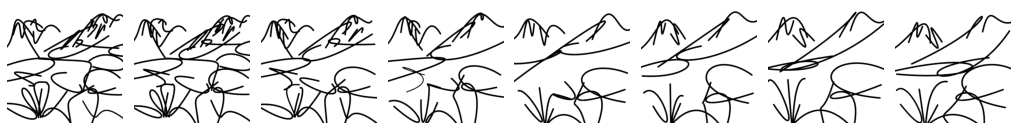

In [131]:
layers = [2,7,8,11]
divs = [0.35,0.45,0.5,0.9]
resize_obj=0
object_or_background = "background"
images = ["woman_city", "semi-complex", "man_flowers"]
# images = ["man_flowers"]
save_results=1
output_path = f"/home/vinker/dev/background_project/paper_results/ablations/our_results"

for im_name_ in images:
    im_name = f"{im_name_}_mask"
    for i, layer in enumerate(layers):
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_org = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)        
        ratios = [float(item) for item in ratios_org.split(',')]
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        path_to_res = f"/home/vinker/dev/background_project/experiements/our_results"
        images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None)
        draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_step{step}", output_path=output_path, save_results=save_results)
        # ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, divs[i], resize_obj)
        # plt.figure(figsize=(10,4))
        # # plt.figure(figsize=(5,4))
        # plt.subplot(1,2,1)
        # plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name=f"l{layer}_{im_name_}_step1_lclip2lsparse", output_path=output_path, save_results=save_results)
        # # plt.show()
        # # plt.close()
        # plt.subplot(1,2,2)
        # # plt.figure(figsize=(5,4))
        # plot_num_strokes(num_strokes_res, im_name=f"l{layer}_{im_name_}_step1_nstrokes", output_path=output_path, save_results=save_results)
        # plt.show()
        # plt.close()

# GRADNORM Bug Fix

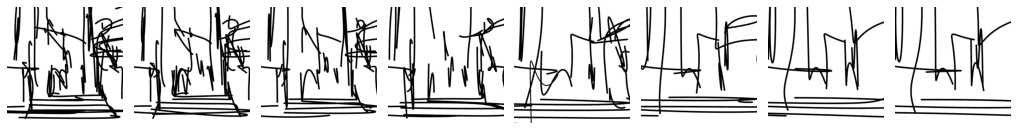

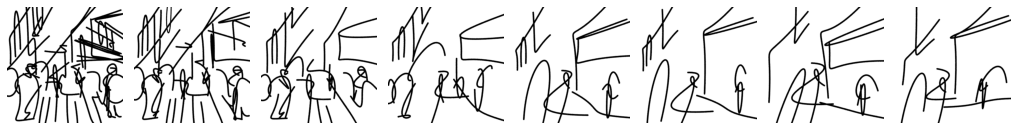

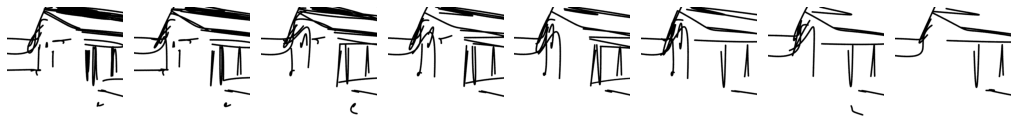

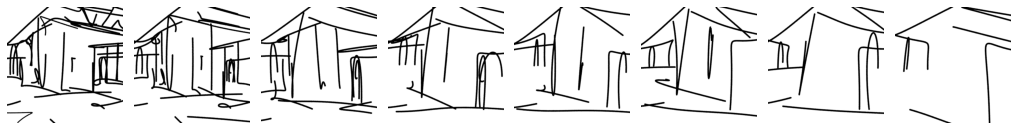

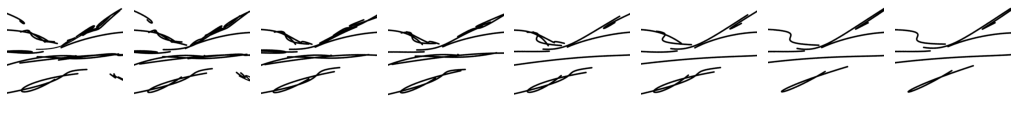

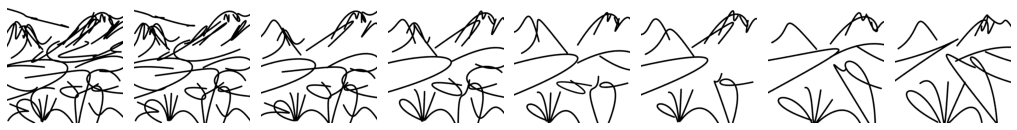

In [89]:
step = "0.9"

layers = [2,11]
divs = [0.35,0.9]
resize_obj=0
object_or_background = "background"
images = ["woman_city","semi-complex", "man_flowers"]
# images = ["woman_city"]
save_results=0
output_path = f"/home/vinker/dev/background_project/paper_results/ablations/stepsize{step}"

for im_name_ in images:
    im_name = f"{im_name_}_mask"
    for i, layer in enumerate(layers):
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_org = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)        
        ratios = [float(item) for item in ratios_org.split(',')]
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        path_to_res = f"/home/vinker/dev/background_project/experiements/gradnorm_bug/"
        images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None)
        draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_original", output_path=output_path, save_results=save_results)
        # ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, divs[i], resize_obj)
        # plt.figure(figsize=(10,4))
        # # plt.figure(figsize=(5,4))
        # plt.subplot(1,2,1)
        # plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name=f"l{layer}_{im_name_}_step1_lclip2lsparse", output_path=output_path, save_results=save_results)
        # # plt.show()
        # # plt.close()
        # plt.subplot(1,2,2)
        # # plt.figure(figsize=(5,4))
        # plot_num_strokes(num_strokes_res, im_name=f"l{layer}_{im_name_}_step1_nstrokes", output_path=output_path, save_results=save_results)
        # plt.show()
        # plt.close()

# Sanity check - general example

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


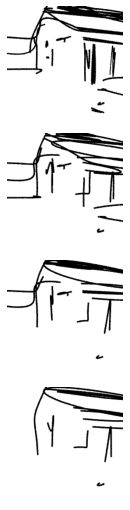

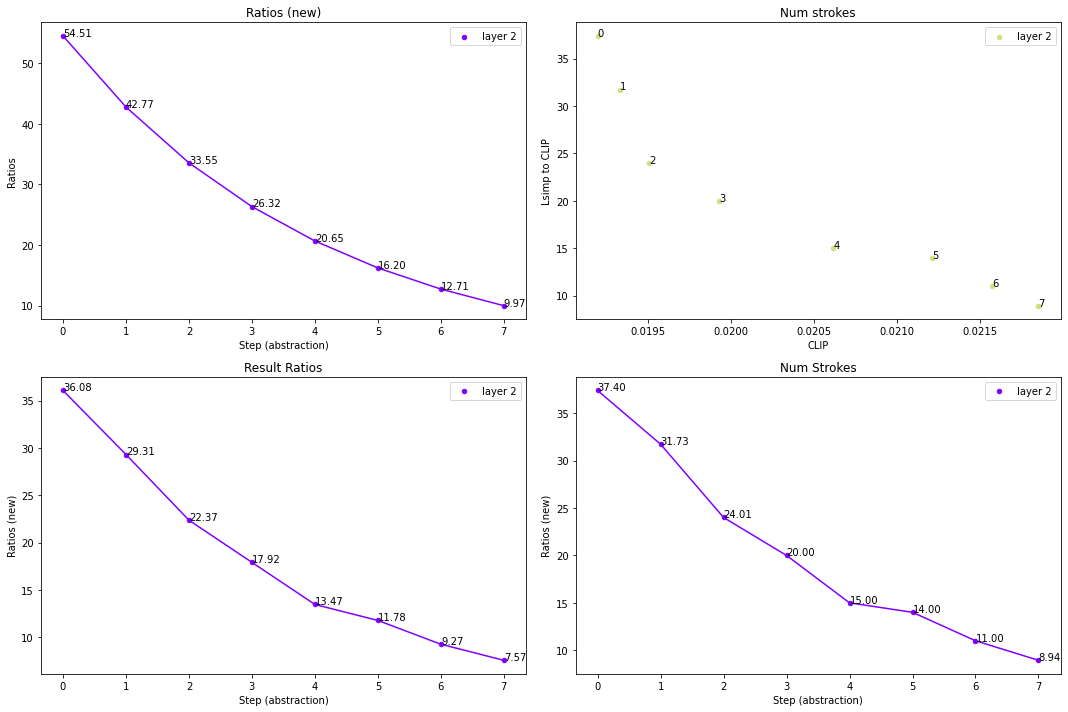

In [320]:
images=["semi-complex"]#, "ballerina"]
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/"
    
object_or_background = "background"
layers = [2,7,8,11]
divs = [0.35,0.45,0.5,0.9]
layers = [2]
divs = [0.35]
draw_matrix_and_graphs(object_or_background, images, layers, path_to_res, divs, step=2)
get_layer_stats(object_or_background, images, layers, path_to_res, divs, step=2, resize_obj=0)

# Our results

layer[2] ratios[34.479,27.052,21.225,16.652,13.065,10.251,8.043,6.31]


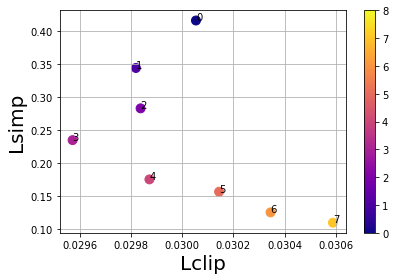

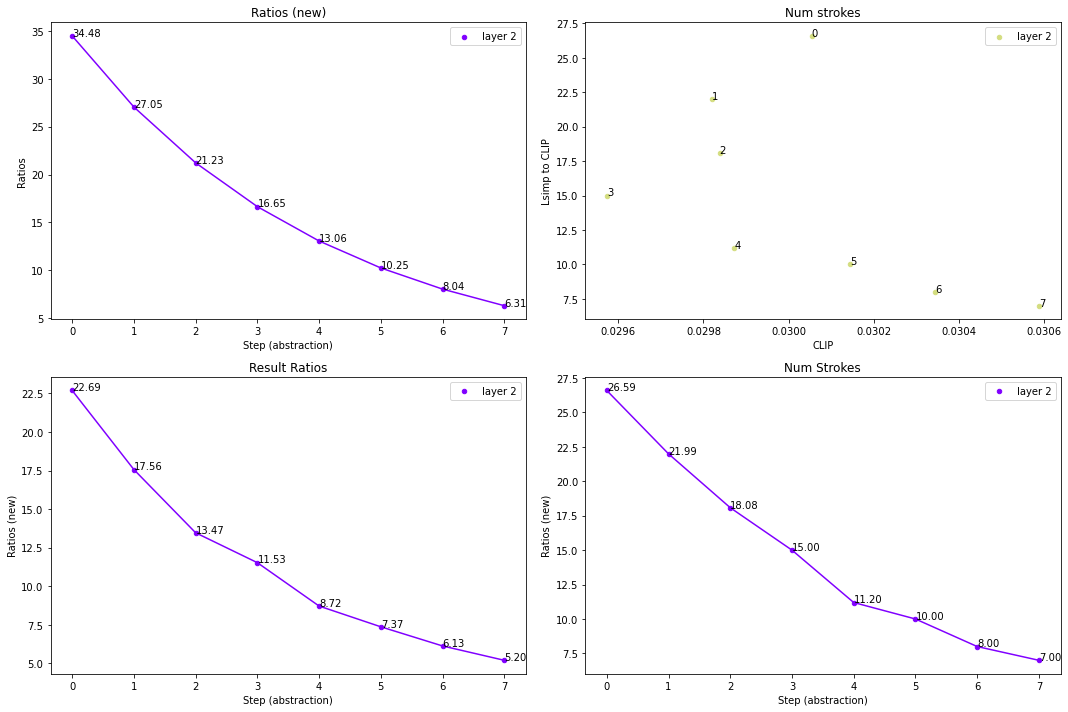

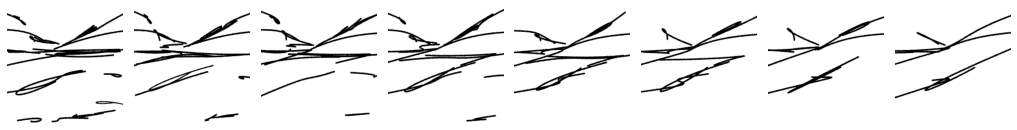

layer[7] ratios[28.736,21.036,15.399,11.273,8.252,6.041,4.422,3.237]


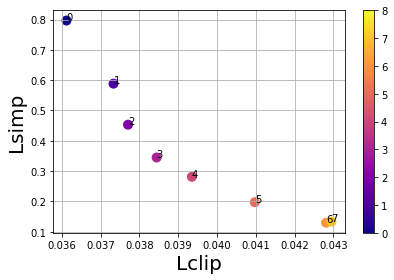

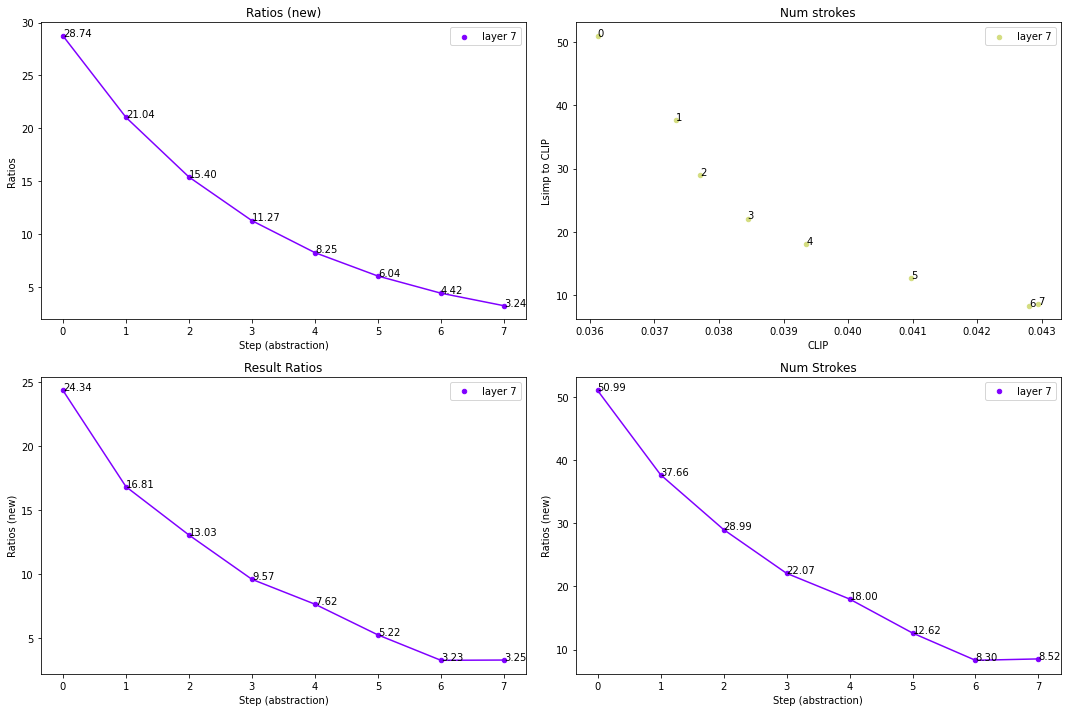

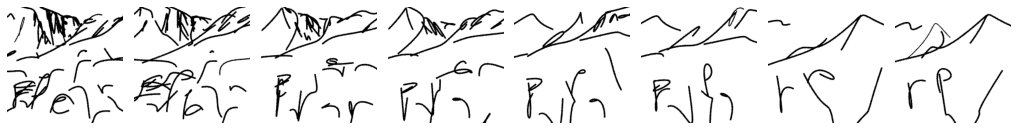

layer[8] ratios[16.661,11.781,8.331,5.891,4.165,2.945,2.083,1.473]


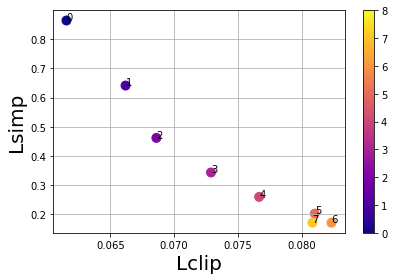

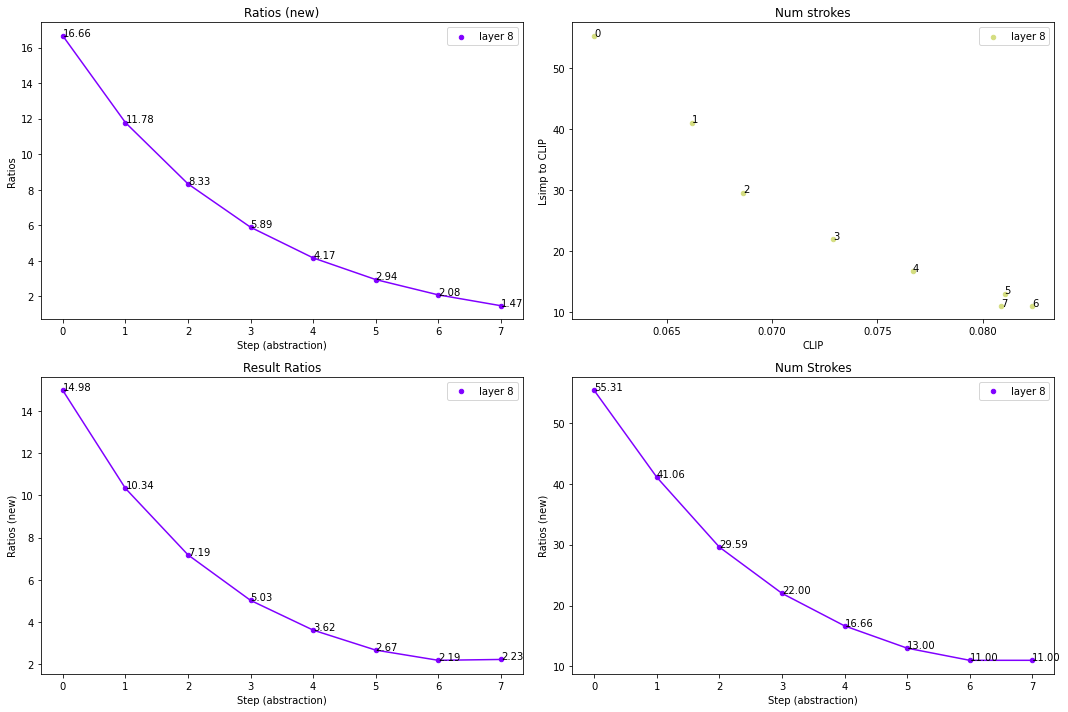

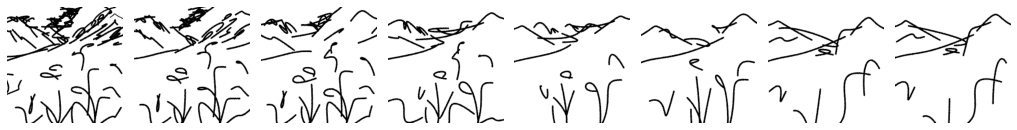

layer[11] ratios[5.242,2.809,1.505,0.807,0.432,0.232,0.124,0.067]


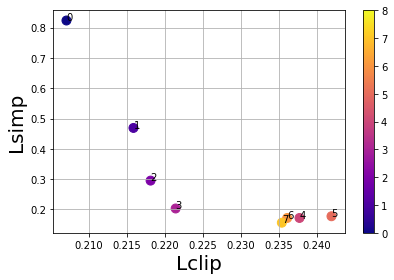

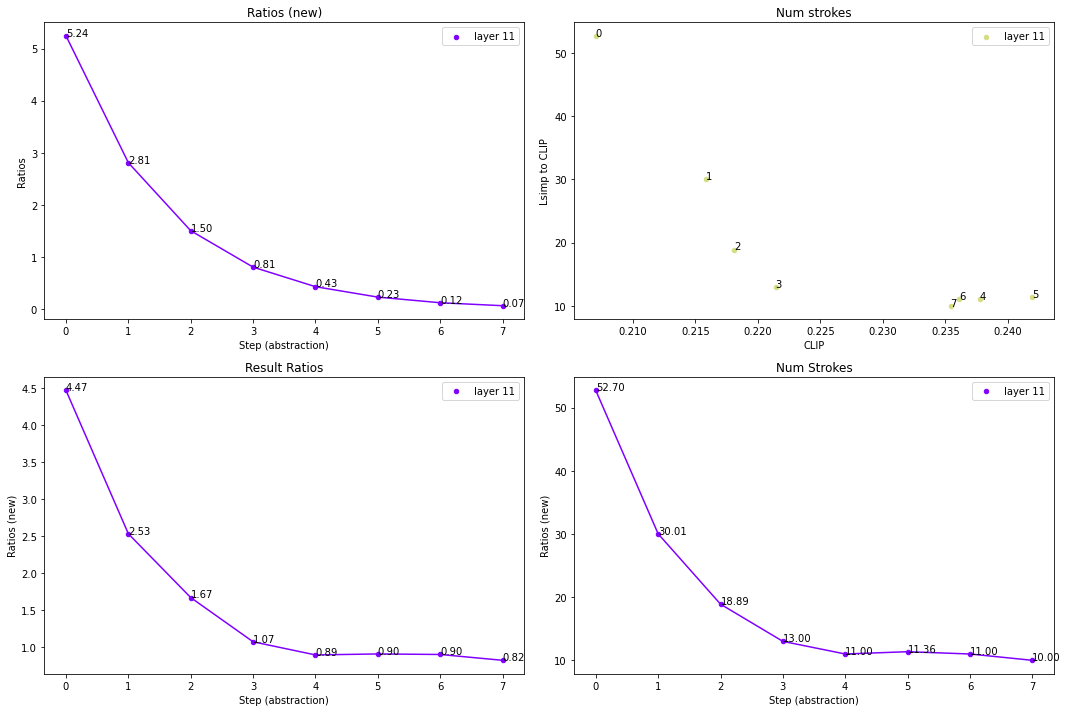

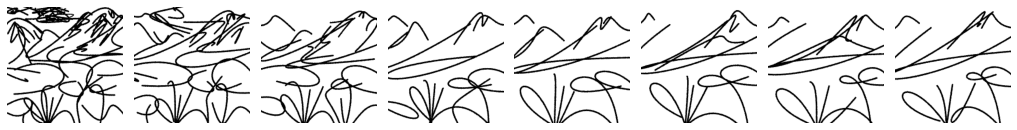

In [41]:
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
layers = [2,7,8,11]
divs = [0.35,0.45,0.5,0.9]
object_or_background = "background"
# im_name_ = "semi-complex"
im_name_ = "man_flowers"
# im_name_ = "assaf"
im_name = f"{im_name_}_mask"
resize_obj=0
ratios_res_dict = {}
for i, layer in enumerate(layers):
    res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
    min_div = divs[i]
    ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
    print(f"layer[{layer}] ratios[{ratios_str}]")
    
    ratios = [float(item) for item in ratios_str.split(',')]
    ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, min_div, resize_obj)
    plot_strokes_to_clip(num_strokes_res, clip_loss_res)
    ratios_res_dict[layer] = ratios_str
    
    get_layer_stats(object_or_background, [im_name_], [layer], path_to_res, [min_div], step=1, resize_obj=0)
    images = get_sketches(layer, ratios, im_name, min_div, resize_obj, path_to_res, params=None, ablation_name_pref="")
    draw_images(images, step=1)

# Test 1 - visualising a smooth and non smooth graph

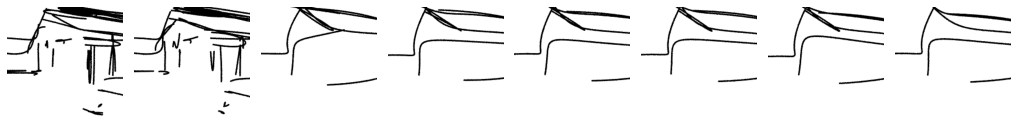

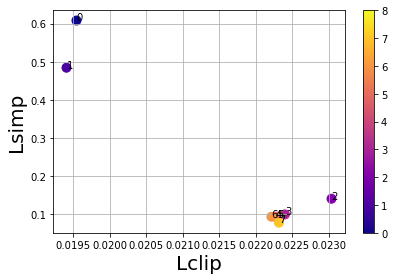

In [12]:
path_to_res = "/home/vinker/dev/background_project/experiements/ablation_ratios_13_10/"
ratios_l2, layer, min_div = [20.839,14.736,10.42,7.368,5.21,3.684,2.605,1.842], 2, 0.35
ablation_name_pref = "same8"
ratios_l2, layer, min_div = [37.376,27.361,20.03,14.662,10.734,7.857,5.752,4.211], 2, 0.35
ablation_name_pref = "same7"

ratios_l2, layer, min_div = [37.376,27.361,20.03,14.662,10.734,7.857,5.752,4.211], 11, 0.35
ablation_name_pref = "same7"


ratios_l2, layer, min_div = [37.376,32.704,28.032,23.36,10.688,5.016,2.344,0.672], 7, 0.35
ratios_l2, layer, min_div = [37.376,32.704,28.032,23.36,10.688,5.016,2.344,0.672], 7, 0.35
# ratios_l2, layer, min_div = [37.376,32.704,28.032,23.36,18.688,14.016,9.344,4.672], 7, 0.35
ablation_name_pref = "linear7"
# ratios_l2, layer, min_div = [54.507,47.694,40.88,34.067,27.254,20.44,13.627,6.813], 2, 0.35
# ablation_name_pref = "linear2"
# ratios_l2, layer, min_div = [7.344,6.426,5.508,4.59,3.672,2.754,1.836,0.918], 11, 0.35
# ablation_name_pref = "linear11"

ratios_l2, layer, min_div = [37.376,32.12,26.864,21.608,16.352,11.096,5.84,0.584], 7, 0.35
ablation_name_pref = "linear9s"


# ratios_l2, layer, min_div = [37.376,34.704,30.032,23.36,18.688,14.016,9.344,4.672], 7, 0.35
# ablation_name_pref = "linear7"
ratios_l2, layer = [54.507,42.765,10.42,7.368,5.21,3.684,2.605,1.842],2
ablation_name_pref = "jump2"
# ratios_l2, layer = [54.507,42.765,33.553,14.662,10.734,7.857,5.752,4.211],2
# ablation_name_pref = "jump"

im_name_ = "semi-complex"
im_name = f"{im_name_}_mask"
object_or_background = "background"

res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
ratios = [float(item) for item in ratios_str.split(',')]
images = get_sketches(layer, ratios_l2, im_name, min_div, resize_obj, path_to_res, params=None, ablation_name_pref=ablation_name_pref)
# get_res_filename_ratio
draw_images(images, step=1)
ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios_l2, im_name, min_div, resize_obj, ablation_name_pref=ablation_name_pref)
plot_strokes_to_clip(num_strokes_res, clip_loss_res)

# Test 2 - linear v.s. exp

In [52]:
# get the weights by reducing an equal number of strokes each time.
def get_ratios_dict(layers, im_name_, object_or_background, resize_obj, divs):
    # get the set of ratios
    ratios_res_dict = {}
    for i, layer in enumerate(layers):
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
        print(f"layer[{layer}] ratios[{ratios_str}]")
        ratios_res_dict[layer] = ratios_str
    return ratios_res_dict

def get_linear(ratios_, linear_step):
    ratios = [float(item) for item in ratios_.split(',')]
    r1 = ratios[0]
    clip_loss = 1 / r1
    num_s_new = 64
    step = linear_step
    linear_ratios = [r1]
    ri = r1
    for i in range(7):
        # if i > 3:
        #     step = 12
        num_s_new = (num_s_new - step) 
        ri = (num_s_new / 64) / clip_loss
        linear_ratios.append(ri)
    return ratios_to_str(linear_ratios)

def get_linear_ratios(layers, im_name_, object_or_background, resize_obj, divs, linear_step):
    linear_ratios_dict = {}
    ratios_res_dict = get_ratios_dict(layers, im_name_, object_or_background, resize_obj, divs)
    for i, layer in enumerate(layers):
        linear_ratios = get_linear(ratios_res_dict[layer], linear_step)
        print(f"layer[{layer}] linear ratios[{linear_ratios}]")
        linear_ratios_dict[layer] = linear_ratios
    return linear_ratios_dict, ratios_res_dict

def plot_num_strokes(num_strokes_res, im_name="", output_path="", save_results=0):
    ylabel = "Num Strokes"
    xlabel = "Step"
    ys = num_strokes_res
    x_vals = range(len(num_strokes_res))
    scaled_z = np.array(range(8)) / 8
    colormap = plt.cm.get_cmap('plasma') # 'plasma' or 'viridis'
    colors = colormap(scaled_z)
    sc = plt.scatter(x_vals, ys, s=80,c=colors)
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=8)
    plt.colorbar(sm)
    for k in range(len(ys)):
        plt.annotate("{:.2f}".format(ys[k]), (x_vals[k], ys[k]), fontsize=10)
       
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.title("Num Strokes", fontsize=18)
    plt.grid()
    plt.tight_layout()
    if save_results:
        plt.savefig(f"{output_path}/{im_name}.png", dpi=300)

def plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name="", output_path="", save_results=0):
    ylabel = "Lsimp"
    xlabel = "Lclip"
    ys = np.array(num_strokes_res) / 64
    x_vals = clip_loss_res
    scaled_z = np.array(range(8)) / 8
    colormap = plt.cm.get_cmap('plasma') # 'plasma' or 'viridis'
    colors = colormap(scaled_z)
    sc = plt.scatter(x_vals, ys, s=80,c=colors)
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=8)
    plt.colorbar(sm)
    for k in range(len(ys)):
        if x_vals is None:
            plt.annotate("{:.2f}".format(ys[k]), (x_vals[k], ys[k]), fontsize=10)
        else:
            plt.annotate("{:.0f}".format(k), (x_vals[k], ys[k]), fontsize=10)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.title("Lsimp(Lclip)", fontsize=18)
    plt.grid()
    plt.tight_layout()
    if save_results:
        plt.savefig(f"{output_path}/{im_name}.png", dpi=300)


In [344]:
layers = [2,7,8,11]
divs = [0.35,0.45,0.5,0.9]
resize_obj=0
im_name_ = "man_flowers"
im_name = f"{im_name_}_mask"
object_or_background = "background"

ablation_name_pref = "linear8"
linear_step = 8
linear_ratios_dict, ratios_res_dict = get_linear_ratios(layers, im_name_, object_or_background, resize_obj, divs, linear_step)

layer[2] ratios[34.479,27.052,21.225,16.652,13.065,10.251,8.043,6.31]
layer[7] ratios[28.736,21.036,15.399,11.273,8.252,6.041,4.422,3.237]
layer[8] ratios[16.661,11.781,8.331,5.891,4.165,2.945,2.083,1.473]
layer[11] ratios[5.242,2.809,1.505,0.807,0.432,0.232,0.124,0.067]
layer[2] linear ratios[34.479,30.169,25.859,21.549,17.239,12.93,8.62,4.31]
layer[7] linear ratios[28.736,25.144,21.552,17.96,14.368,10.776,7.184,3.592]
layer[8] linear ratios[16.661,14.578,12.496,10.413,8.331,6.248,4.165,2.083]
layer[11] linear ratios[5.242,4.587,3.931,3.276,2.621,1.966,1.31,0.655]


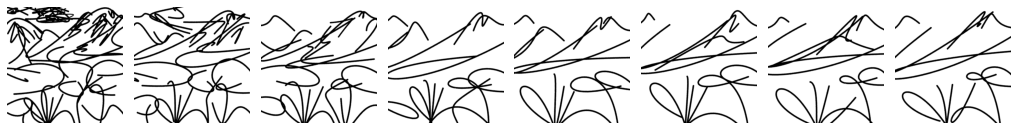

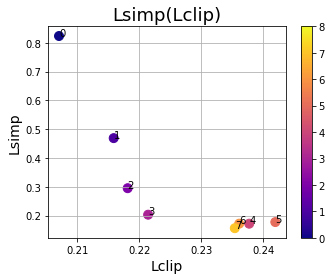

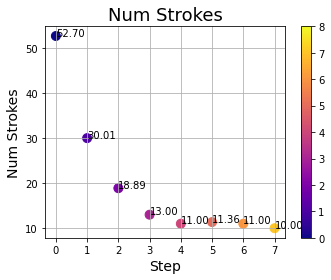

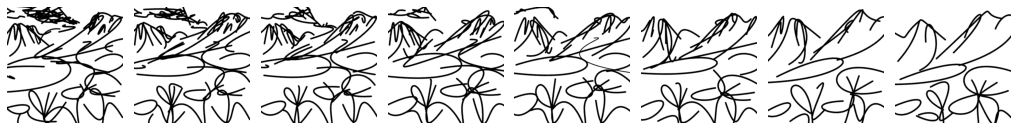

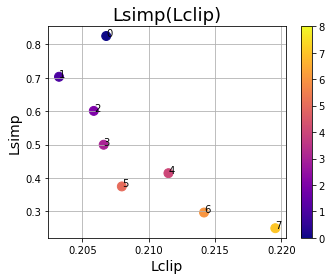

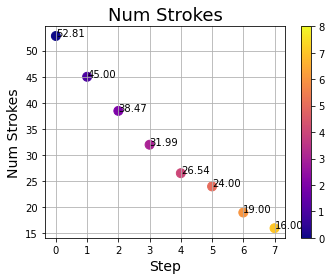

In [345]:
# layers_to_show = [2,7,8,11]
# divs = [0.35,0.45,0.5,0.9]
layers_to_show = [11]
divs = [0.9]
output_path = "/home/vinker/dev/background_project/paper_results/ablations/linear_fk"

for i, layer in enumerate(layers_to_show):
    ratios_org = ratios_res_dict[layer]
    ratios = [float(item) for item in ratios_org.split(',')]
    res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
    path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
    images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None)
    draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_exp", output_path=output_path, save_results=1)
    ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, divs[i], resize_obj)
    # plt.figure(figsize=(10,4))
    plt.figure(figsize=(5,4))
    # plt.subplot(1,2,1)
    plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name=f"l{layer}_{im_name_}_exp_lclip2lsparse", output_path=output_path, save_results=1)
    plt.show()
    plt.close()
    plt.figure(figsize=(5,4))
    # plt.subplot(1,2,2)
    plot_num_strokes(num_strokes_res, im_name=f"l{layer}_{im_name_}_exp_nstrokes", output_path=output_path, save_results=1)
    plt.show()
    plt.close()
    
    ratios_linear = linear_ratios_dict[layer]
    ratios = [float(item) for item in ratios_linear.split(',')]
    res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
    path_to_res = "/home/vinker/dev/background_project/experiements/ablation_ratios_13_10/"
    images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None, ablation_name_pref=ablation_name_pref)
    draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_linear", output_path=output_path, save_results=1)
    ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, divs[i], resize_obj, ablation_name_pref=ablation_name_pref)
    # plt.figure(figsize=(10,4))
    plt.figure(figsize=(5,4))
    # plt.subplot(1,2,1)
    plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name=f"l{layer}_{im_name_}_linear_lclip2lsparse", output_path=output_path, save_results=1)
    plt.show()
    plt.close()
    # plt.subplot(1,2,2)
    plt.figure(figsize=(5,4))
    plot_num_strokes(num_strokes_res, im_name=f"l{layer}_{im_name_}_linear_nstrokes", output_path=output_path, save_results=1)
    plt.show()
    plt.close()

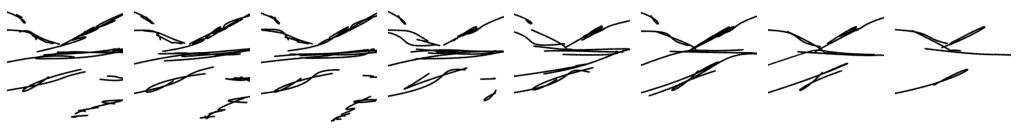

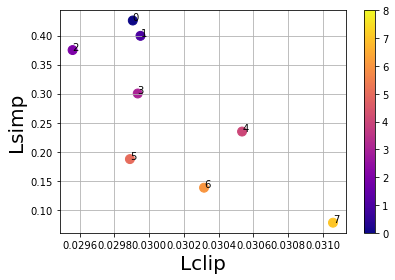

In [32]:
path_to_res = "/home/vinker/dev/background_project/experiements/ablation_ratios_13_10/"
ratios_l2, layer, min_div = [34.479,30.169,25.859,21.549,17.239,12.93,8.62,4.31], 2, 0.35
# ratios_l2, layer, min_div = [28.736,25.144,21.552,17.96,14.368,10.776,7.184,3.592], 7, 0.35
ablation_name_pref = "linear8"

im_name_ = "man_flowers"
im_name = f"{im_name_}_mask"
object_or_background = "background"

res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
ratios = [float(item) for item in ratios_str.split(',')]
images = get_sketches(layer, ratios_l2, im_name, min_div, resize_obj, path_to_res, params=None, ablation_name_pref=ablation_name_pref)
# get_res_filename_ratio
draw_images(images, step=1)
ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios_l2, im_name, min_div, resize_obj, ablation_name_pref=ablation_name_pref)
plot_strokes_to_clip(num_strokes_res, clip_loss_res)

# Test 3 - no finetune for MLPloc

layer[2] ratios[54.507,42.765,33.553,26.325,20.654,16.205,12.714,9.975]
layer[11] ratios[7.344,3.936,2.109,1.13,0.606,0.325,0.174,0.093]


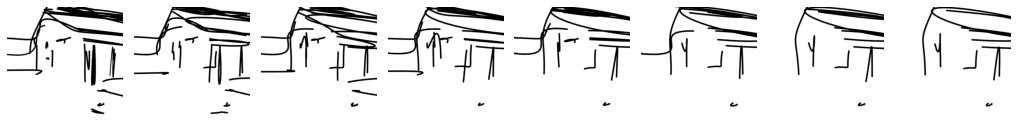

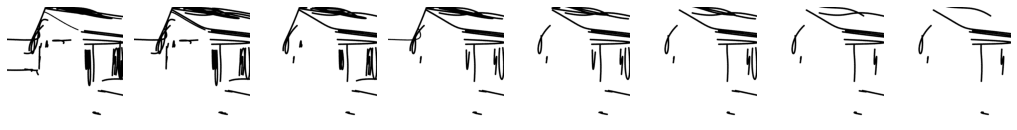

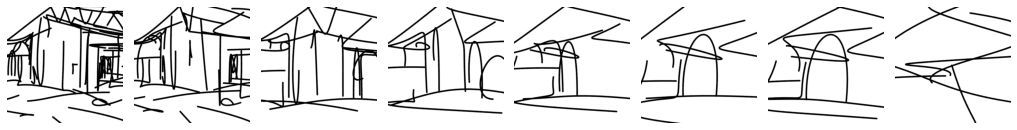

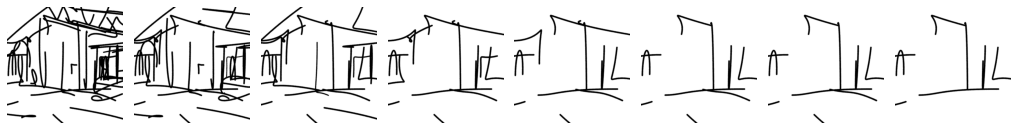

In [41]:
# layers_to_show = [2,7,8,11]
# divs = [0.35,0.45,0.5,0.9]
layers = [2,7,8,11]
divs = [0.35,0.45,0.5,0.9]
layers = [2,11]
divs = [0.35,0.9]
resize_obj=0
im_name_ = "semi-complex"
im_name = f"{im_name_}_mask"
object_or_background = "background"

ablation_name_pref = "_MLPloc0"
save_results=0
output_path = "/home/vinker/dev/background_project/paper_results/ablations/no_mlp_loc"
ratios_res_dict = get_ratios_dict(layers, im_name_, object_or_background, resize_obj, divs)

for i, layer in enumerate(layers):
    ratios_org = ratios_res_dict[layer]
    ratios = [float(item) for item in ratios_org.split(',')]
    
    res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
    path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
    images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None)
    draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_original", output_path=output_path, save_results=save_results)
    
    res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
    path_to_res = "/home/vinker/dev/background_project/experiements/noMLPloc/"
    images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None, ablation_name_pref=ablation_name_pref)
    draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_noMLPloc", output_path=output_path, save_results=save_results)
    

# Test 4 - replcae Lratio with |Lsparse - target strokes|

In [90]:
# get the weights by reducing an equal number of strokes each time.
def get_ratios_dict(layers, im_name_, object_or_background, resize_obj, divs):
    # get the set of ratios
    ratios_res_dict = {}
    for i, layer in enumerate(layers):
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
        print(f"layer[{layer}] ratios[{ratios_str}]")
        ratios_res_dict[layer] = ratios_str
    return ratios_res_dict


def get_target_num_strokes(ratios_):
    # print("input", ratios_)
    ratios = [float(item) for item in ratios_.split(',')]
    r1 = ratios[0]
    clip_loss = 1 / r1
    print("clip_loss",clip_loss)
    linear_ratios = []
    for i in range(8):
        ri = ratios[i]
        num_s = (clip_loss * ri) * 64
        # ri = (num_s_new / 64) / clip_loss
        linear_ratios.append(num_s)
    return ratios_to_str(linear_ratios)

def get_linear_ratios(layers, im_name_, object_or_background, resize_obj, divs):
    linear_ratios_dict = {}
    ratios_res_dict = get_ratios_dict(layers, im_name_, object_or_background, resize_obj, divs)
    print("=" * 10)
    for i, layer in enumerate(layers):
        linear_ratios = get_target_num_strokes(ratios_res_dict[layer])#get_linear(ratios_res_dict[layer], linear_step)
        print(f"layer[{layer}] linear ratios[{linear_ratios}]")
        linear_ratios_dict[layer] = linear_ratios
    return linear_ratios_dict, ratios_res_dict





In [115]:
layers = [11]#,7,8,11]
divs = [0.9]#,0.45,0.5,0.9]
# layers = [11]#,7,8,11]
# divs = [0.9]#,0.45,0.5,0.9]
resize_obj=0
object_or_background = "background"

print("="*20, im_name_, "="*20)
im_name_ = "woman_city"
im_name = f"{im_name_}_mask"
linear_ratios_dict, ratios_res_dict = get_linear_ratios(layers, im_name_, object_or_background, resize_obj, divs)
print("="*20, im_name_, "="*20)
im_name_ = "man_flowers"
im_name = f"{im_name_}_mask"
linear_ratios_dict, ratios_res_dict = get_linear_ratios(layers, im_name_, object_or_background, resize_obj, divs)
# print("="*20, im_name_, "="*20)
im_name_ = "semi-complex"
im_name = f"{im_name_}_mask"
linear_ratios_dict, ratios_res_dict = get_linear_ratios(layers, im_name_, object_or_background, resize_obj, divs)

==================== man_flowers ====================
layer[11] ratios[5.335,2.859,1.532,0.821,0.44,0.236,0.126,0.068]
clip_loss 0.18744142455482662
layer[11] linear ratios[64.0,34.297,18.378,9.849,5.278,2.831,1.512,0.816]
==================== woman_city ====================
layer[11] ratios[5.242,2.809,1.505,0.807,0.432,0.232,0.124,0.067]
clip_loss 0.19076688286913393
layer[11] linear ratios[64.0,34.295,18.375,9.853,5.274,2.833,1.514,0.818]
layer[11] ratios[7.344,3.936,2.109,1.13,0.606,0.325,0.174,0.093]
clip_loss 0.13616557734204793
layer[11] linear ratios[64.0,34.301,18.379,9.847,5.281,2.832,1.516,0.81]


In [116]:
a = np.array([64,32,16,8])
a / 64

array([1.   , 0.5  , 0.25 , 0.125])

layer[11] ratios[7.344,3.936,2.109,1.13,0.606,0.325,0.174,0.093]


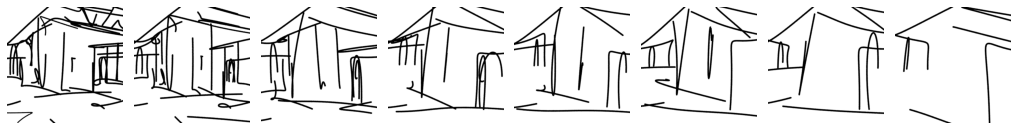

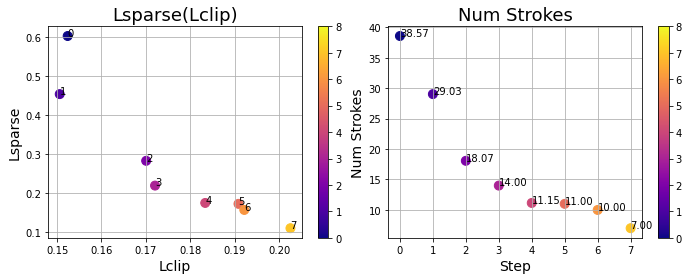

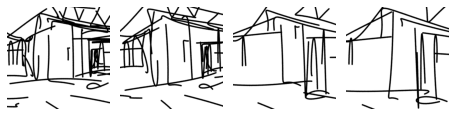

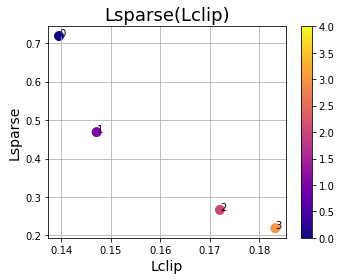

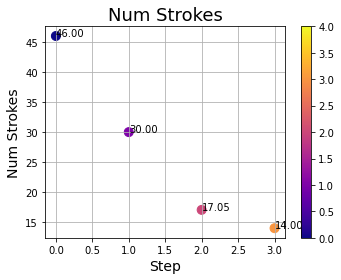

In [117]:
# ablation_name_pref = "_MLPloc0"
save_results=1
output_path = "/home/vinker/dev/background_project/paper_results/ablations/directLs_fix"
ratios_res_dict = get_ratios_dict(layers, im_name_, object_or_background, resize_obj, divs)
ratios_str_dict = {
    2: "1.0,0.785,0.616,0.483,0.379,0.297,0.233,0.183",
    # 11: "1.0,0.536,0.287,0.154,0.082,0.044,0.024,0.013",
    11: "1.0,0.5,0.25,0.125",
}
for i, layer in enumerate(layers):
    ratios_org = ratios_res_dict[layer]
    ratios = [float(item) for item in ratios_org.split(',')]
    
    res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
    # path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
    path_to_res = "/home/vinker/dev/background_project/experiements/gradnorm_bug/"
    images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None)
    draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_original", output_path=output_path, save_results=save_results)
    ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, divs[i], resize_obj)
    plt.figure(figsize=(10,4))
    # plt.figure(figsize=(5,4))
    plt.subplot(1,2,1)
    plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name=f"l{layer}_{im_name_}_exp_lclip2lsparse", output_path=output_path, save_results=save_results)
    # plt.show()
    # plt.close()
    plt.subplot(1,2,2)
    # plt.figure(figsize=(5,4))
    plot_num_strokes(num_strokes_res, im_name=f"l{layer}_{im_name_}_exp_nstrokes", output_path=output_path, save_results=save_results)
    plt.show()
    plt.close()
    
    ratios_org = linear_ratios_dict[layer]
    ratios_org = ratios_str_dict[layer]
    ratios = [float(item) for item in ratios_org.split(',')]
    res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
    path_to_res = "/home/vinker/dev/background_project/experiements/directLs_fixA/"
    images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None)
    draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_directLr", output_path=output_path, save_results=save_results)
    ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, divs[i], resize_obj)
    # plt.figure(figsize=(10,4))
    plt.figure(figsize=(5,4))
    # plt.subplot(1,2,1)
    plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name=f"l{layer}_{im_name_}_directLr_lclip2lsparse", output_path=output_path, save_results=save_results)
    plt.show()
    plt.close()
    # plt.subplot(1,2,2)
    plt.figure(figsize=(5,4))
    plot_num_strokes(num_strokes_res, im_name=f"l{layer}_{im_name_}_directLr_nstrokes", output_path=output_path, save_results=save_results)
    plt.show()
    plt.close()

# Test 5 - no L_sparse minimization

layer[11] ratios[5.335,2.859,1.532,0.821,0.44,0.236,0.126,0.068]


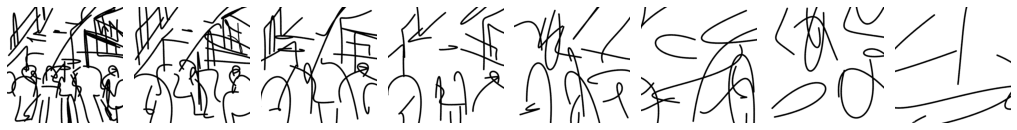

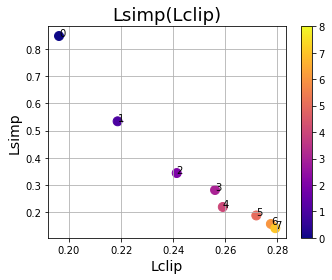

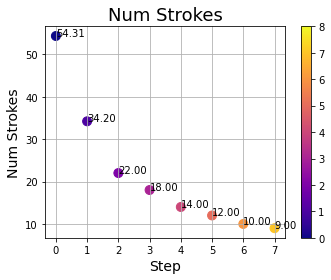

In [106]:
layers = [2,11]#,7,8,11]
divs = [0.35,0.9]#,0.45,0.5,0.9]
layers = [11]#,7,8,11]
divs = [0.9]#,0.45,0.5,0.9]
resize_obj=0
object_or_background = "background"

im_name_ = "woman_city"
im_name = f"{im_name_}_mask"

# ablation_name_pref = "_MLPloc0"
save_results=0
output_path = "/home/vinker/dev/background_project/paper_results/ablations/direct_Lratio"
ratios_res_dict = get_ratios_dict(layers, im_name_, object_or_background, resize_obj, divs)

for i, layer in enumerate(layers):
    # ratios_org = ratios_res_dict[layer]
    # ratios = [float(item) for item in ratios_org.split(',')]
    # res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
    # path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
    # images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None)
    # draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_original", output_path=output_path, save_results=1)
    # ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, divs[i], resize_obj)
    # # plt.figure(figsize=(10,4))
    # plt.figure(figsize=(5,4))
    # # plt.subplot(1,2,1)
    # plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name=f"l{layer}_{im_name_}_exp_lclip2lsparse", output_path=output_path, save_results=1)
    # plt.show()
    # plt.close()
    # # plt.subplot(1,2,2)
    # plt.figure(figsize=(5,4))
    # plot_num_strokes(num_strokes_res, im_name=f"l{layer}_{im_name_}_exp_nstrokes", output_path=output_path, save_results=1)
    # plt.show()
    # plt.close()
    
    ratios_org = ratios_res_dict[layer]
    ratios = [float(item) for item in ratios_org.split(',')]
    res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
    path_to_res = "/home/vinker/dev/background_project/experiements/noLsparse/"
    images = get_sketches(layer, ratios, im_name, divs[i], resize_obj, path_to_res, params=None)
    draw_images(images, step=1, im_name=f"l{layer}_{im_name_}_noLsparse", output_path=output_path, save_results=save_results)
    ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios, im_name, divs[i], resize_obj)
    # plt.figure(figsize=(10,4))
    plt.figure(figsize=(5,4))
    # plt.subplot(1,2,1)
    plot_strokes_to_clip(num_strokes_res, clip_loss_res, im_name=f"l{layer}_{im_name_}_directLr_lclip2lsparse", output_path=output_path, save_results=save_results)
    plt.show()
    plt.close()
    # plt.subplot(1,2,2)
    plt.figure(figsize=(5,4))
    plot_num_strokes(num_strokes_res, im_name=f"l{layer}_{im_name_}_directLr_nstrokes", output_path=output_path, save_results=save_results)
    plt.show()
    plt.close()

# Test 7 - run with the same set of ratios

In [121]:
# get the weights by reducing an equal number of strokes each time.
def get_ratios_dict(layers, im_name_, object_or_background, resize_obj, divs):
    # get the set of ratios
    ratios_res_dict = {}
    for i, layer in enumerate(layers):
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
        print(f"layer[{layer}] ratios[{ratios_str}]")
        ratios_res_dict[layer] = ratios_str
    return ratios_res_dict


def get_target_num_strokes(ratios_):
    # print("input", ratios_)
    ratios = [float(item) for item in ratios_.split(',')]
    r1 = ratios[0]
    clip_loss = 1 / r1
    print("clip_loss",clip_loss)
    linear_ratios = []
    for i in range(8):
        ri = ratios[i]
        num_s = (clip_loss * ri) * 64
        # ri = (num_s_new / 64) / clip_loss
        linear_ratios.append(num_s)
    return ratios_to_str(linear_ratios)

def get_linear_ratios(layers, im_name_, object_or_background, resize_obj, divs):
    linear_ratios_dict = {}
    ratios_res_dict = get_ratios_dict(layers, im_name_, object_or_background, resize_obj, divs)
    print("=" * 10)
    for i, layer in enumerate(layers):
        linear_ratios = get_target_num_strokes(ratios_res_dict[layer])#get_linear(ratios_res_dict[layer], linear_step)
        # print(f"layer[{layer}] linear ratios[{linear_ratios}]")
        linear_ratios_dict[layer] = linear_ratios
    return linear_ratios_dict, ratios_res_dict



layers = [2,7,8,11]
divs = [0.35,0.45,0.5,0.9]
resize_obj=0
object_or_background = "background"

# print("="*20, im_name_, "="*20)
# im_name_ = "woman_city"
# im_name = f"{im_name_}_mask"
# linear_ratios_dict, ratios_res_dict = get_linear_ratios(layers, im_name_, object_or_background, resize_obj, divs)
# print("="*20, im_name_, "="*20)
im_name_ = "man_flowers"
im_name = f"{im_name_}_mask"
linear_ratios_dict, ratios_res_dict = get_linear_ratios(layers, im_name_, object_or_background, resize_obj, divs)
# print("="*20, im_name_, "="*20)
# im_name_ = "semi-complex"
# im_name = f"{im_name_}_mask"
# linear_ratios_dict, ratios_res_dict = get_linear_ratios(layers, im_name_, object_or_background, resize_obj, divs)

layer[2] ratios[34.479,27.052,21.225,16.652,13.065,10.251,8.043,6.31]
layer[7] ratios[28.736,21.036,15.399,11.273,8.252,6.041,4.422,3.237]
layer[8] ratios[16.661,11.781,8.331,5.891,4.165,2.945,2.083,1.473]
layer[11] ratios[5.242,2.809,1.505,0.807,0.432,0.232,0.124,0.067]
clip_loss 0.02900316134458656
clip_loss 0.03479955456570156
clip_loss 0.060020406938359035
clip_loss 0.19076688286913393


# Test 2 - replace ratio loss with Lspase direct opt

In [321]:
# calculate target num strokes
# on layer 7, 2, 11? for semi-complex
def get_strokes_target(r_1_k, step_size_l, num_ratios):
    clip_loss = 1 / r_1_k
    print(clip_loss)
    r_j_k = r_1_k
    ratios_k = [r_1_k]
    for j in range(4):
        r_j_k = r_j_k / 2
        ratios_k.append(r_j_k)
    start_ys, start_x, end_x_addition = 0, 0, 0
    popt = get_func(ratios_k, start_x=0, start_ys=0) # fit the function to ratios_k
    x_1_k = func_inv([r_1_k], *popt)

    step_size = step_size_l
    num_steps = num_ratios - start_x + end_x_addition
    start_ = x_1_k[0]
    end = num_steps * step_size
    # sample the function from the initial scaled r_1 with the corresponding step size
    new_xs_layer_l = np.linspace(start_, end - step_size + start_, num_steps) 
    # print("new_xs_layer_l", new_xs_layer_l)
    ratios_li = func(new_xs_layer_l, *popt)
    target_strokes = (clip_loss * ratios_li)
    print(ratios_to_str(target_strokes))
    ratios_str = ratios_to_str(ratios_li)
    xs_layer_l_str = ratios_to_str(new_xs_layer_l)
    # print(ratios_str)

get_strokes_target(54.507, step_size_l=0.35, num_ratios=8)
get_strokes_target(37.376, step_size_l=0.45, num_ratios=8)
get_strokes_target(20.839, step_size_l=0.5, num_ratios=8)
get_strokes_target(7.344, step_size_l=0.9, num_ratios=8)
    

0.018346267451886913
1.0,0.785,0.616,0.483,0.379,0.297,0.233,0.183
0.026755136986301373
1.0,0.732,0.536,0.392,0.287,0.21,0.154,0.113
0.04798694755026633
1.0,0.707,0.5,0.354,0.25,0.177,0.125,0.088
0.13616557734204793
1.0,0.536,0.287,0.154,0.082,0.044,0.024,0.013


In [322]:
def plot_strokes_to_clip(num_strokes_res, clip_loss_res, title):
    ylabel = "Lsimp"
    xlabel = "Lclip"
    ys = np.array(num_strokes_res) / 64
    x_vals = clip_loss_res
    scaled_z = np.array(range(8)) / 8
    colormap = plt.cm.get_cmap('plasma') # 'plasma' or 'viridis'
    colors = colormap(scaled_z)
    sc = plt.scatter(x_vals, ys, s=80,c=colors)
    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=8)
    plt.colorbar(sm)
    for k in range(len(ys)):
        if x_vals is None:
            plt.annotate("{:.2f}".format(ys[k]), (x_vals[k], ys[k]), fontsize=10)
        else:
            plt.annotate("{:.0f}".format(k), (x_vals[k], ys[k]), fontsize=10)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    # cbar = plt.colorbar()
    plt.title(title)
    # plt.legend()
    plt.grid()
    plt.tight_layout()
    

def plot_num_strokes(num_strokes_res, num_strokes_target, num_strokes_res_):
    num_strokes_target_ = np.array(num_strokes_target) * 64
    plt.scatter(range(len(num_strokes_res)), num_strokes_res, label="res")
    plt.scatter(range(len(num_strokes_target)), num_strokes_target_, label="target")
    plt.scatter(range(len(num_strokes_res_)), num_strokes_res_, label="res ratio")
    plt.title("Num Strokes")
    plt.legend()
    plt.show()
    plt.close()
    
    


ablation_name_pref = "lsparse"
im_name_ = "semi-complex"
im_name = f"{im_name_}_mask"
object_or_background = "background"

ratios_abl = [[1.0,0.785,0.616,0.483,0.379,0.297,0.233,0.183],
             [1.0,0.732,0.536,0.392,0.287,0.21,0.154,0.113],
             [1.0,0.707,0.5,0.354,0.25,0.177,0.125,0.088],
             [1.0,0.536,0.287,0.154,0.082,0.044,0.024,0.013]]
layers = [2,7,8,11]
divs = [0.35, 0.45, 0.5, 0.9]

for i in range(len(layers)):
    path_to_res = "/home/vinker/dev/background_project/experiements/ablation_ratios_13_10/"
    ratios_l2, layer, min_div = ratios_abl[i], layers[i], divs[i]
    images = get_sketches(layer, ratios_l2, im_name, min_div, resize_obj, path_to_res, params=None, ablation_name_pref=ablation_name_pref)
    
    ratios_res, num_strokes_res, clip_loss_res = get_single_layer_stat(layer, ratios_l2, im_name, min_div, resize_obj=0, ablation_name_pref=ablation_name_pref)
    
    
    
    path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/"
    res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
    ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
    print(f"layer[{layer}] ratios[{ratios_str}]")
    ratios = [float(item) for item in ratios_str.split(',')]
    ratios_res_, num_strokes_res_, clip_loss_res_ = get_single_layer_stat(layer, ratios, im_name, min_div, resize_obj)   
    images_ = get_sketches(layer, ratios, im_name, min_div, resize_obj, path_to_res, params=None, ablation_name_pref="")
    
    draw_images(images, step=1)
    draw_images(images_, step=1)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plot_strokes_to_clip(num_strokes_res, clip_loss_res, "direct Lsparse")
    plt.subplot(1,2,2)
    plot_strokes_to_clip(num_strokes_res_, clip_loss_res_, "Lratio")
    plt.show()
    plt.close()
    
    plot_num_strokes(num_strokes_res, ratios_l2, num_strokes_res_)

FileNotFoundError: [Errno 2] No such file or directory: '/home/vinker/dev/background_project/experiements/all_together_09_09//background_l2_64s_semi-complex_mask_resize1_resize1'

In [257]:
# polygon from mask
path_to_files = "/home/vinker/dev/input_images/background_sketching/" # to input images
im_name = "house3"
target_path = f"{path_to_files}/{im_name}.jpg"
resize_obj = 1
target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
mask_np = original_mask[0].permute(1,2,0).cpu().numpy()
imageio.imsave("mask_house.png", mask_np)

    

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


tensor(1., device='cuda:0') tensor(0.0965, device='cuda:0')
167 399 261 404


In [242]:
%cd /home/diffvg/apps
!ls
!python refine_svg.py "/home/vinker/dev/backgroundCLIPasso/CLIPasso/notebooks/house_mask.svg" "/home/vinker/dev/backgroundCLIPasso/CLIPasso/notebooks/mask_house.png"



/home/diffvg/apps
Makefile		      single_curve_sdf.py
curve_subdivision.py	      single_curve_sdf_trans.py
finite_difference_comp.py     single_curve_tf.py
gaussian_blur.py	      single_ellipse.py
generative_models	      single_ellipse_transform.py
geometry.py		      single_gradient.py
image_compare.py	      single_open_curve.py
imgs			      single_open_curve_thickness.py
optimize_pixel_filter.py      single_path.py
painterly_rendering.py	      single_path_sdf.py
quadratic_distance_approx.py  single_polygon.py
refine_svg.py		      single_rect.py
render_svg.py		      single_stroke.py
seam_carving.py		      single_stroke_tf.py
shared_edge_compare.py	      sketch_gan.py
simple_transform_svg.py       style_transfer.py
single_circle.py	      svg_brush.py
single_circle_outline.py      svg_parse_test.py
single_circle_sdf.py	      test_eval_positions.py
single_circle_tf.py	      textureSyn
single_curve.py		      texture_synthesis.py
single_curve_outline.py
LPIPS is untested
Traceback (most rec

In [243]:
%cd /home/vinker/dev/backgroundCLIPasso/CLIPasso/notebooks

/home/vinker/dev/backgroundCLIPasso/CLIPasso/notebooks


# Quantitative - Fidelity

In [214]:
def get_matrix(im_name, layers, object_or_background, divs, path_to_res, path_to_initial_sketches, resize_obj=0, params=None, background_opacity=1, save_results=0):
    matrix = []
    op = 1
    if object_or_background == "background":
        im_name = f"{im_name}_mask"
        op = background_opacity
        
    for i, layer in enumerate(layers):
        sketches_col = []
        res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
        if resize_obj:
            res_filename += f"_resize{resize_obj}"
        path_res = f"{path_to_initial_sketches}/{res_filename}"
        if not os.path.isdir(path_res):
            res_filename = f"{res_filename}_resize{resize_obj}"
        svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{res_filename}")
        path_svg = f"{path_to_initial_sketches}/{res_filename}/{svg_filename}"
        sketch = notebooks_utils.read_svg(path_svg, resize_obj=resize_obj, params=params, opacity=op, multiply=save_results)
        
        min_div = divs[i]
        ratios_str = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)
        ratios = [float(item) for item in ratios_str.split(',')]

        ratios_res = []
        num_strokes_res = []
        
        k = 0
        for j, r in enumerate(ratios):
            test_name_pref = f"l{layer}_64s_{im_name}_{min_div}"
            if resize_obj:
                test_name_pref += f"_resize{resize_obj}"
            path_res = f"{path_to_res}/{res_filename}"
            if not os.path.isdir(path_res):
                res_filename = f"{res_filename}_resize{resize_obj}"
            res_filename = f"ratio{r}_{test_name_pref}"
            best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res}/{res_filename}")
            path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"
            sketch = notebooks_utils.read_svg(path_best_im, resize_obj=resize_obj, params=params, opacity=op, multiply=save_results)
            sketches_col.append(sketch)
        matrix.append(sketches_col)

    matrix = np.array(matrix)
    return matrix


def draw_matrix(matrix_back, matrix_obj, mask_np, step=1, save_results=0, output_path=""):
    combined_matrix = []
    mean_over_rows = matrix_back.mean(axis=0)
    
    if save_results:
        mask_np = resize(mask_np, (mask_np.shape[0] * 2, mask_np.shape[1] * 2), order=0)

    figa = plt.figure(figsize=(int(matrix_back.shape[0] * 2), int(matrix_back.shape[1] * 2)))
    counter=0
    for layer_index in range(matrix_back.shape[0]):
        k = 0
        sketches_col = []
        for ratio_index in range(matrix_back.shape[1]):
            if ratio_index % step == 0:
                mean_back = mean_over_rows[ratio_index]
                back_cur = matrix_back[layer_index, ratio_index]
                back_cur_op, mean_back_op = 1 - back_cur, 1 - mean_back 
                # back_blend = 0.5 * back_cur_op + 0.5 * mean_back_op
                back_blend = 1 * back_cur_op
                back_blend = 1 - back_blend
                back_blend[mask_np == 1] = 1

                obj_cur = matrix_obj[layer_index, ratio_index]
                obj_cur_op = (1 - obj_cur)
                back_blend_op = (1 - back_blend) #* 0.7
                back_blend_op[obj_cur_op > 0.0] = 1 * obj_cur_op[obj_cur_op > 0.0]
                # back_blend = 1 - back_blend_op
                im_blend = 1 - back_blend_op
                plt.subplot(matrix_back.shape[1], matrix_back.shape[0], (k) * matrix_back.shape[0] + layer_index + 1)
                plt.imshow(im_blend)
                plt.axis("off")
                k += 1
                
                if save_results:
                    r_i = int(ratio_index / step)
                    filename = f"{im_name}_{counter}"#row{r_i}col{layer_index}"
                    im_blend_ = ((im_blend / im_blend.max()) * 255).astype(np.uint8)
                    imageio.imsave(f"{output_path}/{filename}.png", im_blend_)
                    counter+=1
                    im_blend = resize(im_blend, (im_blend.shape[0] / 2, mask_np.shape[1] / 2), order=0)
                sketches_col.append(im_blend)
                    
        combined_matrix.append(sketches_col)
                    
    plt.tight_layout()
    plt.show()
    plt.close()
    return combined_matrix

def plot_input_im_and_mask(target, mask_np):
    plt.subplot(1,2,1)
    plt.imshow(target[0].permute(1,2,0).cpu())
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(mask_np)
    plt.axis("off")
    plt.show()
    plt.close()

class XDoG_(object):
    def __init__(self):
        super(XDoG_, self).__init__()
        self.gamma=0.98
        self.phi=200
        self.eps=-0.1
        self.sigma=0.8
        self.binarize=True
        
    def __call__(self, im, k=10):
        if im.shape[2] == 3:
            im = rgb2gray(im)
        imf1 = gaussian_filter(im, self.sigma)
        imf2 = gaussian_filter(im, self.sigma * k)
        imdiff = imf1 - self.gamma * imf2
        imdiff = (imdiff < self.eps) * 1.0  + (imdiff >= self.eps) * (1.0 + np.tanh(self.phi * imdiff))
        imdiff -= imdiff.min()
        imdiff /= imdiff.max()
        if self.binarize:
            th = threshold_otsu(imdiff)
            imdiff = imdiff >= th
        imdiff = imdiff.astype('float32')
        return imdiff

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


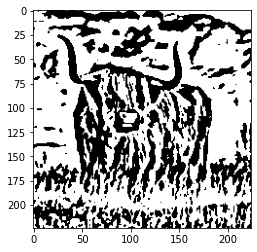

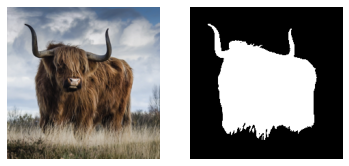

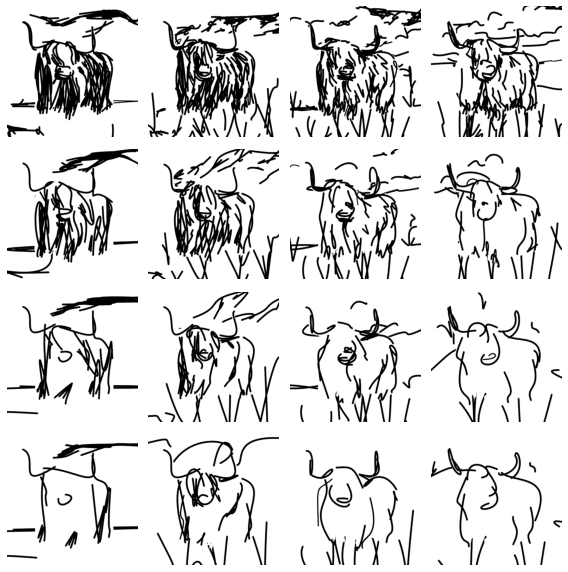

In [310]:
path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # semantic axis
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_09_10_fix3/" # simplification axis
output_path = "/home/vinker/dev/background_project/paper_results/matrices"

images = ["bull"]
layers = [2,7,8,11]
resize_obj=1
save_results=1

xdog = XDoG_()
            
for im_name in images:
    output_path_cur = f"{output_path}/{im_name}"
    if not os.path.exists(output_path_cur):
        os.mkdir(output_path_cur)
    target_path = f"{path_to_files}/{im_name}.jpg"
    target, mask, masked_target, original_mask, params = notebooks_utils.get_target(target_path, device, image_scale=224, resize_obj=resize_obj, return_params=resize_obj)
    im_xdog = xdog(target[0].permute(1,2,0).cpu().numpy(), k=5)
    plt.imshow(im_xdog, cmap="gray")
    plt.show()
    mask_np = original_mask[0].permute(1,2,0).cpu().numpy()
    plot_input_im_and_mask(target, mask_np)
    
    divs = [0.35,0.45,0.5,0.9]
    matrix_back = get_matrix(im_name, layers, "background", divs, path_to_res, path_to_initial_sketches, resize_obj=0, params=params, background_opacity=1, save_results=save_results)
    divs = [0.45,0.4,0.5,0.9]
    matrix_obj = get_matrix(im_name, layers, "object", divs, path_to_res, path_to_initial_sketches, resize_obj=1, params=params, save_results=save_results)
    
    combined_matrix = draw_matrix(matrix_back, matrix_obj, mask_np, step=2, save_results=save_results, output_path=output_path_cur)
    
    

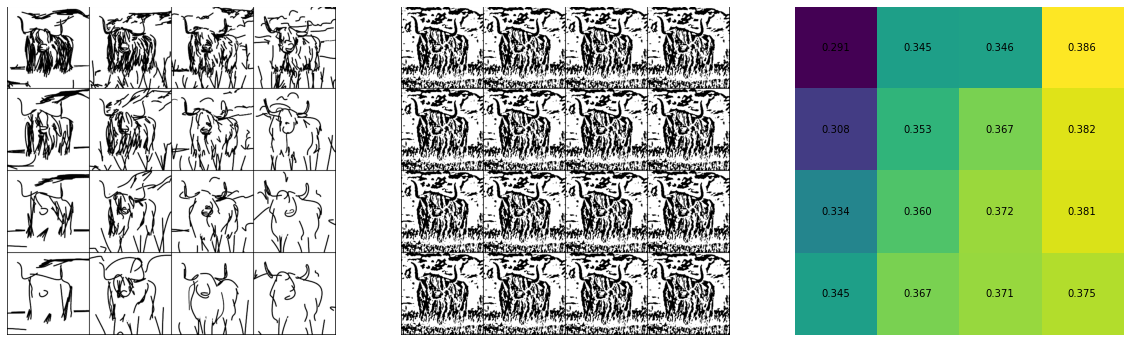

In [311]:
import torchvision

combined_matrix_np = np.array(combined_matrix)[:,:,:,:,0] #[col,row]
combined_matrix_np = np.transpose(combined_matrix_np, axes=(1,0,2,3))
xdog_matrix= np.array([im_xdog]*4)
xdog_matrix= np.array([xdog_matrix,]*4)
plt.figure(figsize=(20,20))
grid_ = torch.Tensor(np.concatenate(combined_matrix_np, axis=0)).unsqueeze(1)
grid_img = torchvision.utils.make_grid(grid_, nrow=4)
plt.subplot(1,3,1)
plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")
plt.axis("off")

# xdog_matrix = np.zeros(xdog_matrix.shape)
grid_ = torch.Tensor(np.concatenate(xdog_matrix, axis=0)).unsqueeze(1)
grid_img = torchvision.utils.make_grid(grid_, nrow=4)
plt.subplot(1,3,2)
plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
dist = np.sqrt(((xdog_matrix - combined_matrix_np) ** 2).sum(axis=-1).sum(axis=-1))
dist = ((xdog_matrix - combined_matrix_np) ** 2).sum(axis=-1).sum(axis=-1) / (224*224)
plt.imshow(dist)
plt.axis("off")
for i in range(4):
    for j in range(4):
        plt.text(j,i, "{:.3f}".format(dist[i,j]), horizontalalignment='center', verticalalignment='center')

plt.show()

In [312]:
from pathlib import Path
model, preprocess = clip.load("ViT-B/32", device)
model.eval()
sketches_path = f"{output_path}/{im_name}"

# the images are saved to a directory using the names "black_man_0.png", "black_man_1.png", ... for example
# images are sorted like that : [row0col0,row1col0....]
image_paths = [path for path in Path(sketches_path).glob("*png")]
images_path = list(sorted(image_paths, key=lambda x: int(Path(x).stem.split("_")[-1])))
images = [Image.open(image) for image in images_path]

input_image = Image.open(target_path)
image_input = preprocess(input_image).unsqueeze(0).to(device)
queries = [preprocess(image).unsqueeze(0).to(device) for image in images]
with torch.no_grad():
    image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    query_features = [model.encode_image(image) for image in queries]
    query_features = [feats / feats.norm(dim=-1, keepdim=True) for feats in query_features]

similarities = [(image_features @ feats.T).cpu().item() for feats in query_features]
similarity_matrix = np.array(similarities).reshape(4,4)
# plt.imshow(similarity_matrix)

torch.Size([16, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


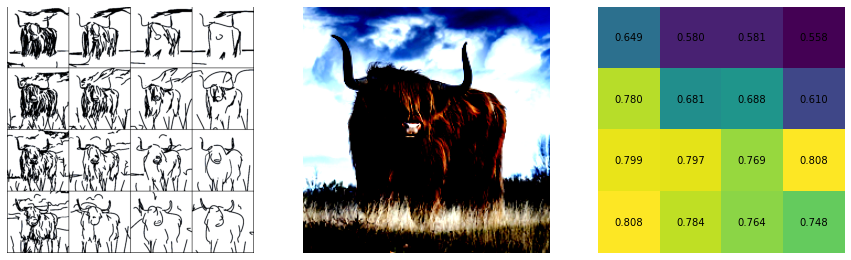

In [313]:
plt.figure(figsize=(15,15))
print(torch.stack(queries).squeeze(1).shape)
grid_img = torchvision.utils.make_grid(torch.stack(queries).squeeze(1).cpu(), nrow=4)
plt.subplot(1,3,1)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")

grid_img = torchvision.utils.make_grid(image_input.cpu(), nrow=4)
plt.subplot(1,3,2)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(similarity_matrix)
plt.axis("off")
for i in range(4):
    for j in range(4):
        plt.text(j,i, "{:.3f}".format(similarity_matrix[i,j]), horizontalalignment='center', verticalalignment='center')

plt.show()

# Quantitative semantics

In [258]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


In [314]:
imagenet_classes = ["tench", "goldfish", "great white shark", "tiger shark", "hammerhead shark", "electric ray", "stingray", "rooster", "hen", "ostrich", "brambling", "goldfinch", "house finch", "junco", "indigo bunting", "American robin", "bulbul", "jay", "magpie", "chickadee", "American dipper", "kite (bird of prey)", "bald eagle", "vulture", "great grey owl", "fire salamander", "smooth newt", "newt", "spotted salamander", "axolotl", "American bullfrog", "tree frog", "tailed frog", "loggerhead sea turtle", "leatherback sea turtle", "mud turtle", "terrapin", "box turtle", "banded gecko", "green iguana", "Carolina anole", "desert grassland whiptail lizard", "agama", "frilled-necked lizard", "alligator lizard", "Gila monster", "European green lizard", "chameleon", "Komodo dragon", "Nile crocodile", "American alligator", "triceratops", "worm snake", "ring-necked snake", "eastern hog-nosed snake", "smooth green snake", "kingsnake", "garter snake", "water snake", "vine snake", "night snake", "boa constrictor", "African rock python", "Indian cobra", "green mamba", "sea snake", "Saharan horned viper", "eastern diamondback rattlesnake", "sidewinder rattlesnake", "trilobite", "harvestman", "scorpion", "yellow garden spider", "barn spider", "European garden spider", "southern black widow", "tarantula", "wolf spider", "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse", "prairie grouse", "peafowl", "quail", "partridge", "african grey parrot", "macaw", "sulphur-crested cockatoo", "lorikeet", "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "duck", "red-breasted merganser", "goose", "black swan", "tusker", "echidna", "platypus", "wallaby", "koala", "wombat", "jellyfish", "sea anemone", "brain coral", "flatworm", "nematode", "conch", "snail", "slug", "sea slug", "chiton", "chambered nautilus", "Dungeness crab", "rock crab", "fiddler crab", "red king crab", "American lobster", "spiny lobster", "crayfish", "hermit crab", "isopod", "white stork", "black stork", "spoonbill", "flamingo", "little blue heron", "great egret", "bittern bird", "crane bird", "limpkin", "common gallinule", "American coot", "bustard", "ruddy turnstone", "dunlin", "common redshank", "dowitcher", "oystercatcher", "pelican", "king penguin", "albatross", "grey whale", "killer whale", "dugong", "sea lion", "Chihuahua", "Japanese Chin", "Maltese", "Pekingese", "Shih Tzu", "King Charles Spaniel", "Papillon", "toy terrier", "Rhodesian Ridgeback", "Afghan Hound", "Basset Hound", "Beagle", "Bloodhound", "Bluetick Coonhound", "Black and Tan Coonhound", "Treeing Walker Coonhound", "English foxhound", "Redbone Coonhound", "borzoi", "Irish Wolfhound", "Italian Greyhound", "Whippet", "Ibizan Hound", "Norwegian Elkhound", "Otterhound", "Saluki", "Scottish Deerhound", "Weimaraner", "Staffordshire Bull Terrier", "American Staffordshire Terrier", "Bedlington Terrier", "Border Terrier", "Kerry Blue Terrier", "Irish Terrier", "Norfolk Terrier", "Norwich Terrier", "Yorkshire Terrier", "Wire Fox Terrier", "Lakeland Terrier", "Sealyham Terrier", "Airedale Terrier", "Cairn Terrier", "Australian Terrier", "Dandie Dinmont Terrier", "Boston Terrier", "Miniature Schnauzer", "Giant Schnauzer", "Standard Schnauzer", "Scottish Terrier", "Tibetan Terrier", "Australian Silky Terrier", "Soft-coated Wheaten Terrier", "West Highland White Terrier", "Lhasa Apso", "Flat-Coated Retriever", "Curly-coated Retriever", "Golden Retriever", "Labrador Retriever", "Chesapeake Bay Retriever", "German Shorthaired Pointer", "Vizsla", "English Setter", "Irish Setter", "Gordon Setter", "Brittany dog", "Clumber Spaniel", "English Springer Spaniel", "Welsh Springer Spaniel", "Cocker Spaniel", "Sussex Spaniel", "Irish Water Spaniel", "Kuvasz", "Schipperke", "Groenendael dog", "Malinois", "Briard", "Australian Kelpie", "Komondor", "Old English Sheepdog", "Shetland Sheepdog", "collie", "Border Collie", "Bouvier des Flandres dog", "Rottweiler", "German Shepherd Dog", "Dobermann", "Miniature Pinscher", "Greater Swiss Mountain Dog", "Bernese Mountain Dog", "Appenzeller Sennenhund", "Entlebucher Sennenhund", "Boxer", "Bullmastiff", "Tibetan Mastiff", "French Bulldog", "Great Dane", "St. Bernard", "husky", "Alaskan Malamute", "Siberian Husky", "Dalmatian", "Affenpinscher", "Basenji", "pug", "Leonberger", "Newfoundland dog", "Great Pyrenees dog", "Samoyed", "Pomeranian", "Chow Chow", "Keeshond", "brussels griffon", "Pembroke Welsh Corgi", "Cardigan Welsh Corgi", "Toy Poodle", "Miniature Poodle", "Standard Poodle", "Mexican hairless dog (xoloitzcuintli)", "grey wolf", "Alaskan tundra wolf", "red wolf or maned wolf", "coyote", "dingo", "dhole", "African wild dog", "hyena", "red fox", "kit fox", "Arctic fox", "grey fox", "tabby cat", "tiger cat", "Persian cat", "Siamese cat", "Egyptian Mau", "cougar", "lynx", "leopard", "snow leopard", "jaguar", "lion", "tiger", "cheetah", "brown bear", "American black bear", "polar bear", "sloth bear", "mongoose", "meerkat", "tiger beetle", "ladybug", "ground beetle", "longhorn beetle", "leaf beetle", "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant", "grasshopper", "cricket insect", "stick insect", "cockroach", "praying mantis", "cicada", "leafhopper", "lacewing", "dragonfly", "damselfly", "red admiral butterfly", "ringlet butterfly", "monarch butterfly", "small white butterfly", "sulphur butterfly", "gossamer-winged butterfly", "starfish", "sea urchin", "sea cucumber", "cottontail rabbit", "hare", "Angora rabbit", "hamster", "porcupine", "fox squirrel", "marmot", "beaver", "guinea pig", "common sorrel horse", "zebra", "pig", "wild boar", "warthog", "hippopotamus", "ox", "water buffalo", "bison", "ram (adult male sheep)", "bighorn sheep", "Alpine ibex", "hartebeest", "impala (antelope)", "gazelle", "arabian camel", "llama", "weasel", "mink", "European polecat", "black-footed ferret", "otter", "skunk", "badger", "armadillo", "three-toed sloth", "orangutan", "gorilla", "chimpanzee", "gibbon", "siamang", "guenon", "patas monkey", "baboon", "macaque", "langur", "black-and-white colobus", "proboscis monkey", "marmoset", "white-headed capuchin", "howler monkey", "titi monkey", "Geoffroy's spider monkey", "common squirrel monkey", "ring-tailed lemur", "indri", "Asian elephant", "African bush elephant", "red panda", "giant panda", "snoek fish", "eel", "silver salmon", "rock beauty fish", "clownfish", "sturgeon", "gar fish", "lionfish", "pufferfish", "abacus", "abaya", "academic gown", "accordion", "acoustic guitar", "aircraft carrier", "airliner", "airship", "altar", "ambulance", "amphibious vehicle", "analog clock", "apiary", "apron", "trash can", "assault rifle", "backpack", "bakery", "balance beam", "balloon", "ballpoint pen", "Band-Aid", "banjo", "baluster / handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel", "wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "swimming cap", "bath towel", "bathtub", "station wagon", "lighthouse", "beaker", "military hat (bearskin or shako)", "beer bottle", "beer glass", "bell tower", "baby bib", "tandem bicycle", "bikini", "ring binder", "binoculars", "birdhouse", "boathouse", "bobsleigh", "bolo tie", "poke bonnet", "bookcase", "bookstore", "bottle cap", "hunting bow", "bow tie", "brass memorial plaque", "bra", "breakwater", "breastplate", "broom", "bucket", "buckle", "bulletproof vest", "high-speed train", "butcher shop", "taxicab", "cauldron", "candle", "cannon", "canoe", "can opener", "cardigan", "car mirror", "carousel", "tool kit", "cardboard box / carton", "car wheel", "automated teller machine", "cassette", "cassette player", "castle", "catamaran", "CD player", "cello", "mobile phone", "chain", "chain-link fence", "chain mail", "chainsaw", "storage chest", "chiffonier", "bell or wind chime", "china cabinet", "Christmas stocking", "church", "movie theater", "cleaver", "cliff dwelling", "cloak", "clogs", "cocktail shaker", "coffee mug", "coffeemaker", "spiral or coil", "combination lock", "computer keyboard", "candy store", "container ship", "convertible", "corkscrew", "cornet", "cowboy boot", "cowboy hat", "cradle", "construction crane", "crash helmet", "crate", "infant bed", "Crock Pot", "croquet ball", "crutch", "cuirass", "dam", "desk", "desktop computer", "rotary dial telephone", "diaper", "digital clock", "digital watch", "dining table", "dishcloth", "dishwasher", "disc brake", "dock", "dog sled", "dome", "doormat", "drilling rig", "drum", "drumstick", "dumbbell", "Dutch oven", "electric fan", "electric guitar", "electric locomotive", "entertainment center", "envelope", "espresso machine", "face powder", "feather boa", "filing cabinet", "fireboat", "fire truck", "fire screen", "flagpole", "flute", "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster bed", "freight car", "French horn", "frying pan", "fur coat", "garbage truck", "gas mask or respirator", "gas pump", "goblet", "go-kart", "golf ball", "golf cart", "gondola", "gong", "gown", "grand piano", "greenhouse", "radiator grille", "grocery store", "guillotine", "hair clip", "hair spray", "half-track", "hammer", "hamper", "hair dryer", "hand-held computer", "handkerchief", "hard disk drive", "harmonica", "harp", "combine harvester", "hatchet", "holster", "home theater", "honeycomb", "hook", "hoop skirt", "gymnastic horizontal bar", "horse-drawn vehicle", "hourglass", "iPod", "clothes iron", "carved pumpkin", "jeans", "jeep", "T-shirt", "jigsaw puzzle", "rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat", "ladle", "lampshade", "laptop computer", "lawn mower", "lens cap", "letter opener", "library", "lifeboat", "lighter", "limousine", "ocean liner", "lipstick", "slip-on shoe", "lotion", "music speaker", "loupe magnifying glass", "sawmill", "magnetic compass", "messenger bag", "mailbox", "tights", "one-piece bathing suit", "manhole cover", "maraca", "marimba", "mask", "matchstick", "maypole", "maze", "measuring cup", "medicine cabinet", "megalith", "microphone", "microwave oven", "military uniform", "milk can", "minibus", "miniskirt", "minivan", "missile", "mitten", "mixing bowl", "mobile home", "ford model t", "modem", "monastery", "monitor", "moped", "mortar and pestle", "graduation cap", "mosque", "mosquito net", "vespa", "mountain bike", "tent", "computer mouse", "mousetrap", "moving van", "muzzle", "metal nail", "neck brace", "necklace", "baby pacifier", "notebook computer", "obelisk", "oboe", "ocarina", "odometer", "oil filter", "pipe organ", "oscilloscope", "overskirt", "bullock cart", "oxygen mask", "product packet / packaging", "paddle", "paddle wheel", "padlock", "paintbrush", "pajamas", "palace", "pan flute", "paper towel", "parachute", "parallel bars", "park bench", "parking meter", "railroad car", "patio", "payphone", "pedestal", "pencil case", "pencil sharpener", "perfume", "Petri dish", "photocopier", "plectrum", "Pickelhaube", "picket fence", "pickup truck", "pier", "piggy bank", "pill bottle", "pillow", "ping-pong ball", "pinwheel", "pirate ship", "drink pitcher", "block plane", "planetarium", "plastic bag", "plate rack", "farm plow", "plunger", "Polaroid camera", "pole", "police van", "poncho", "pool table", "soda bottle", "plant pot", "potter's wheel", "power drill", "prayer rug", "printer", "prison", "missile", "projector", "hockey puck", "punching bag", "purse", "quill", "quilt", "race car", "racket", "radiator", "radio", "radio telescope", "rain barrel", "recreational vehicle", "fishing casting reel", "reflex camera", "refrigerator", "remote control", "restaurant", "revolver", "rifle", "rocking chair", "rotisserie", "eraser", "rugby ball", "ruler measuring stick", "sneaker", "safe", "safety pin", "salt shaker", "sandal", "sarong", "saxophone", "scabbard", "weighing scale", "school bus", "schooner", "scoreboard", "CRT monitor", "screw", "screwdriver", "seat belt", "sewing machine", "shield", "shoe store", "shoji screen / room divider", "shopping basket", "shopping cart", "shovel", "shower cap", "shower curtain", "ski", "balaclava ski mask", "sleeping bag", "slide rule", "sliding door", "slot machine", "snorkel", "snowmobile", "snowplow", "soap dispenser", "soccer ball", "sock", "solar thermal collector", "sombrero", "soup bowl", "keyboard space bar", "space heater", "space shuttle", "spatula", "motorboat", "spider web", "spindle", "sports car", "spotlight", "stage", "steam locomotive", "through arch bridge", "steel drum", "stethoscope", "scarf", "stone wall", "stopwatch", "stove", "strainer", "tram", "stretcher", "couch", "stupa", "submarine", "suit", "sundial", "sunglasses", "sunglasses", "sunscreen", "suspension bridge", "mop", "sweatshirt", "swim trunks / shorts", "swing", "electrical switch", "syringe", "table lamp", "tank", "tape player", "teapot", "teddy bear", "television", "tennis ball", "thatched roof", "front curtain", "thimble", "threshing machine", "throne", "tile roof", "toaster", "tobacco shop", "toilet seat", "torch", "totem pole", "tow truck", "toy store", "tractor", "semi-trailer truck", "tray", "trench coat", "tricycle", "trimaran", "tripod", "triumphal arch", "trolleybus", "trombone", "hot tub", "turnstile", "typewriter keyboard", "umbrella", "unicycle", "upright piano", "vacuum cleaner", "vase", "vaulted or arched ceiling", "velvet fabric", "vending machine", "vestment", "viaduct", "violin", "volleyball", "waffle iron", "wall clock", "wallet", "wardrobe", "military aircraft", "sink", "washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle", "hair wig", "window screen", "window shade", "Windsor tie", "wine bottle", "airplane wing", "wok", "wooden spoon", "wool", "split-rail fence", "shipwreck", "sailboat", "yurt", "website", "comic book", "crossword", "traffic or street sign", "traffic light", "dust jacket", "menu", "plate", "guacamole", "consomme", "hot pot", "trifle", "ice cream", "popsicle", "baguette", "bagel", "pretzel", "cheeseburger", "hot dog", "mashed potatoes", "cabbage", "broccoli", "cauliflower", "zucchini", "spaghetti squash", "acorn squash", "butternut squash", "cucumber", "artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith apple", "strawberry", "orange", "lemon", "fig", "pineapple", "banana", "jackfruit", "cherimoya (custard apple)", "pomegranate", "hay", "carbonara", "chocolate syrup", "dough", "meatloaf", "pizza", "pot pie", "burrito", "red wine", "espresso", "tea cup", "eggnog", "mountain", "bubble", "cliff", "coral reef", "geyser", "lakeshore", "promontory", "sandbar", "beach", "valley", "volcano", "baseball player", "bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper", "corn", "acorn", "rose hip", "horse chestnut seed", "coral fungus", "agaric", "gyromitra", "stinkhorn mushroom", "earth star fungus", "hen of the woods mushroom", "bolete", "corn cob", "toilet paper"]
imagenet_templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]


In [284]:
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in classnames:
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights


zeroshot_weights = zeroshot_classifier(imagenet_classes, imagenet_templates)

In [285]:
print(zeroshot_weights.shape)

torch.Size([512, 1000])


In [315]:
query_features_tensor = torch.stack(query_features).squeeze(1)

logits = 100. * query_features_tensor @ zeroshot_weights
pred = logits.topk(max((1, 5)), 1, True, True)[1].t()
# acc1, acc5 = accuracy(logits, target, topk=(1, 5))

text_probs = (100.0 * query_features_tensor.float() @ zeroshot_weights.float()).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

print(pred.shape)
print(top_probs.shape)
print(pred[:,0])
print(top_labels[0,:])

torch.Size([5, 16])
torch.Size([16, 5])
tensor([345, 346, 347,   9, 155], device='cuda:0')
tensor([345, 346, 347,   9, 155])


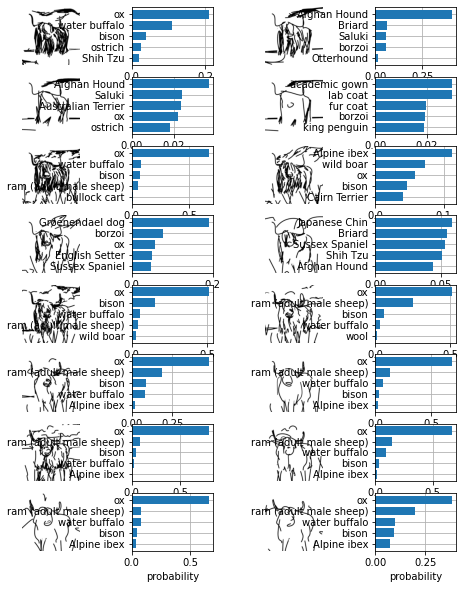

In [316]:
plt.figure(figsize=(8, 10))
original_images = images#[input_image]
# top_probs = pred.T.cpu()
for i, image in enumerate(original_images):
    plt.subplot(8, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(8, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [imagenet_classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

torch.Size([5, 16])
torch.Size([1, 5])
tensor([345, 346, 347,   9, 155], device='cuda:0')
tensor([345, 347, 346, 343, 224])


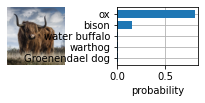

In [317]:
query_features_tensor = torch.stack(query_features).squeeze(1)

logits = 100. * query_features_tensor @ zeroshot_weights
pred = logits.topk(max((1, 5)), 1, True, True)[1].t()
# acc1, acc5 = accuracy(logits, target, topk=(1, 5))

text_probs = (100.0 * image_features.float() @ zeroshot_weights.float()).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

print(pred.shape)
print(top_probs.shape)
print(pred[:,0])
print(top_labels[0,:])

plt.figure(figsize=(8, 10))
original_images = [input_image]
# top_probs = pred.T.cpu()
for i, image in enumerate(original_images):
    plt.subplot(8, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(8, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [imagenet_classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [299]:
pred.shape
# print(pred[:,0])
# print(pred[:,-1])
# a = pred[:,0].cpu().numpy()
# a
# # imagenet_classes[a]
# print([imagenet_classes[ind] for ind in a])

torch.Size([5, 16])

In [259]:
labels = cifar100.classes
labels.append("dog")
labels.append("bull")
text_descriptions = [f"This is a photo of a {label}" for label in labels]
# text_descriptions.append("This is a photo of a dog")
print(text_descriptions)
text_tokens = clip.tokenize(text_descriptions).cuda()

['This is a photo of a apple', 'This is a photo of a aquarium_fish', 'This is a photo of a baby', 'This is a photo of a bear', 'This is a photo of a beaver', 'This is a photo of a bed', 'This is a photo of a bee', 'This is a photo of a beetle', 'This is a photo of a bicycle', 'This is a photo of a bottle', 'This is a photo of a bowl', 'This is a photo of a boy', 'This is a photo of a bridge', 'This is a photo of a bus', 'This is a photo of a butterfly', 'This is a photo of a camel', 'This is a photo of a can', 'This is a photo of a castle', 'This is a photo of a caterpillar', 'This is a photo of a cattle', 'This is a photo of a chair', 'This is a photo of a chimpanzee', 'This is a photo of a clock', 'This is a photo of a cloud', 'This is a photo of a cockroach', 'This is a photo of a couch', 'This is a photo of a crab', 'This is a photo of a crocodile', 'This is a photo of a cup', 'This is a photo of a dinosaur', 'This is a photo of a dolphin', 'This is a photo of a elephant', 'This is

In [267]:
print(zeroshot_weights.shape)

torch.Size([512, 1000])


In [260]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

# query_features_tensor = torch.stack(query_features)
text_probs = (100.0 * image_features.float() @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [261]:
print(image_features.shape)
query_features_tensor = torch.stack(query_features).squeeze(1)
print(query_features_tensor.shape)
print(text_features.shape)

text_probs = (100.0 * query_features_tensor.float() @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

torch.Size([1, 512])
torch.Size([16, 512])
torch.Size([102, 512])


In [132]:
print(np.array(similarities).shape)
a = np.array(range(16))
a
a.reshape(4,4).T

(16,)


array([[ 0,  4,  8, 12],
       [ 1,  5,  9, 13],
       [ 2,  6, 10, 14],
       [ 3,  7, 11, 15]])

In [ ]:
# clip distance
import clip
device = torch.device("cuda:1" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")


model, preprocess = clip.load("ViT-B/32", device)
preprocess_ =  transforms.Compose([
            preprocess.transforms[0],  # Resize
            preprocess.transforms[1],  # CenterCrop
            # preprocess.transforms[-2], 
            preprocess.transforms[-1],  # Normalize
        ])
print(preprocess_)
model.eval()


In [154]:
model, preprocess = clip.load("ViT-B/32", device)
model.eval()

images_path = '/nfs/private/yuval/scene_clipasso/outputs_new_images/black_woman/'
input_image = '/nfs/private/yuval/scene_clipasso/data/input_images_processed/black_woman.jpg'

# the images are saved to a directory using the names "black_man_0.png", "black_man_1.png", ... for example
image_paths = [path for path in Path(images_path).glob("*png")]
images_path = list(sorted(image_paths, key=lambda x: int(Path(x).stem.split("_")[-1])))
images = [Image.open(image) for image in images_path]
input_image = Image.open(target_path)

image_input = preprocess(input_image).unsqueeze(0).to(device)
queries = [preprocess(image).unsqueeze(0).to(device) for image in images]

with torch.no_grad():
    image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    query_features = [model.encode_image(image) for image in queries]
    query_features = [feats / feats.norm(dim=-1, keepdim=True) for feats in query_features]

similarities = [(image_features @ feats.T).cpu().item() for feats in query_features]
similarity_matrix = np.array(similarities)#.reshape(4,4)





In [155]:
print(similarity_matrix.shape)

(0,)


In [147]:
print(image_features.shape)
print(query_features[0].T.shape)

torch.Size([1, 512])


IndexError: list index out of range

In [134]:
images_np = np.array(images)
print(images_np.shape)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'PngImageFile'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


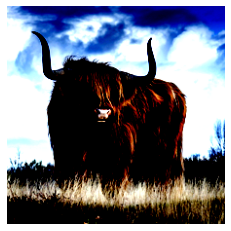

In [99]:
image = Image.open(target_path).convert("RGB").resize((224,224))
image = np.array(image)/255
images = torch.tensor(np.stack([image])).to(device).permute(0,3,1,2)
preprocessed_im = preprocess_(images)
grid_img = torchvision.utils.make_grid(preprocessed_im.cpu(), nrow=16)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [100]:
with torch.no_grad():
    image_features = model.encode_image(preprocessed_im).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
# torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


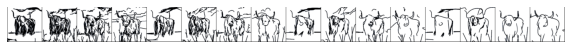

In [106]:
# features of the sketches
combined_matrix_tensor = np.array(combined_matrix)[:,:,:,:,:]
combined_matrix_tensor = np.transpose(combined_matrix_tensor, axes=(1,0,4,2,3))


combined_matrix_tensor = torch.Tensor(np.concatenate(combined_matrix_tensor, axis=0))
preprocessed_matrix = preprocess_(combined_matrix_tensor).to(device)

plt.figure(figsize=(10,10))

grid_img = torchvision.utils.make_grid(preprocessed_matrix.cpu(), nrow=16)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.show()

with torch.no_grad():
    sketch_features = model.encode_image(preprocessed_matrix).float()

In [102]:
sim_matrix = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        sketch_features_cur = sketch_features[j + (i *4)].unsqueeze(0)
        sketch_features_cur /= sketch_features_cur.norm(dim=-1, keepdim=True)
        similarity = sketch_features_cur.cpu().detach().numpy() @ image_features.cpu().detach().numpy().T
        sim_matrix[i,j] = similarity

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


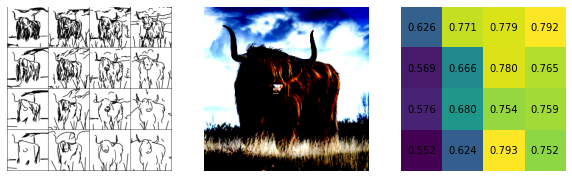

In [104]:
plt.figure(figsize=(10,10))
grid_img = torchvision.utils.make_grid(combined_matrix_tensor, nrow=4)
plt.subplot(1,3,1)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")

grid_img = torchvision.utils.make_grid(preprocessed_im.cpu(), nrow=4)
plt.subplot(1,3,2)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(sim_matrix)
plt.axis("off")
for i in range(4):
    for j in range(4):
        plt.text(j,i, "{:.3f}".format(sim_matrix[i,j]), horizontalalignment='center', verticalalignment='center')

plt.show()

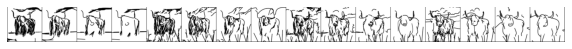

In [74]:
plt.figure(figsize=(10,10))
grid_img = torchvision.utils.make_grid(combined_matrix_tensor.cpu(), nrow=16)
# plt.subplot(1,3,1)
plt.imshow(grid_img.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.show()


(4, 4, 224, 224, 3)
(4, 4, 3, 224, 224)


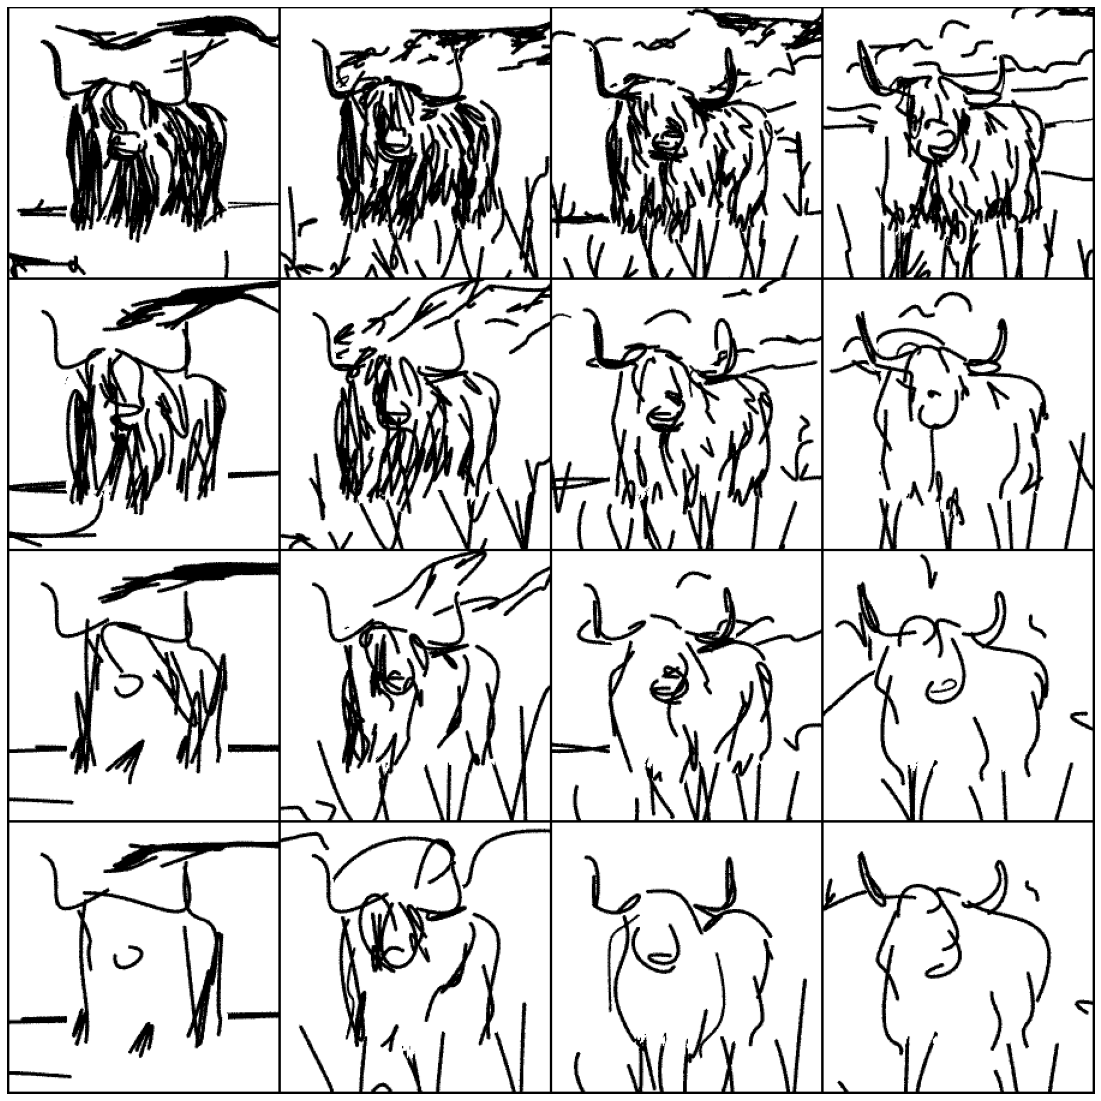